In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)
from numpy.random import Generator, PCG64
import timeit
import plotly.graph_objects as go
from copy import deepcopy

# Auxiliary functions

In [2]:
def exponential_rng(lam = 1.0):  
    """ Generates exponential random number.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
    
    Returns:
        exponential random number with rate lam.
    """
    return -np.log(np.random.rand()) / lam

In [3]:
def homogeneous_poisson_process(lam, T):
    """ Generates arrivals according to a Poisson process.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
        T (int): duration of the Poisson process.
    
    Returns:
        times: arrival times of a Poisson process with rate lam until time T.
    """
    times = []
    t = T - exponential_rng(lam)
    while t > 0:
        times.append(t)
        t -= exponential_rng(lam)
    return times

In [4]:
def non_homogeneous_poisson_process(lam_t, lam_max, T):
    """ Generates arrivals according to non-homogeneous Poisson process with time-dependent rate lam_t. 
    
    Keywords:
        lam_t (function handle): function returning the Poisson process rate at time t.
        lam_max (real): maximum value of lam_t(t) to be used for generating arrivals.
        T (int): duration of Poisson process.
    
    Returns:
        times: array of event times.
        efficiency (real): (0-1) efficiency of non-homogeneous Poisson process.
    """
    times = []
    n = 0 # Internal counter for the total number of events registered during the whole duration T
    t = T - exponential_rng(lam_max)
    while t > 0:
        n += 1
        # If an event occurs at time t, count it with probability p(t) = lam_t(t)/lam_max
        if np.random.rand() < lam_t(t)/lam_max:
            times.append(t)
        t -= exponential_rng(lam_max)
    return times, len(times)/n

In [5]:
def non_homogeneous_poisson_process_piecewise(lam_t, lam_max, T):
    """ Generates Business Passenger arrivals according to non-homogeneous Poisson process with time-dependent rate lam_t. 
    
    Keywords:
        lam_t (function handle): function returning the Poisson process rate at time t.
        lam_max (array): array of maximum values of lam_t(t) and cumulative durations to be used for generating arrivals.
        T (int): duration of Poisson process.

    Returns:
        times: array of event times.
        efficiency (real): (0-1) efficiency of non-homogeneous Poisson process.
    """
    times = []
    n = 0 # Internal counter for the total number of events registered during the whole duration T
    m = len(lam_max[0, :]) # Number of sub-intervals characterised by a constant lam_max
    t = T
    # Main loop
    for interval in range(m):
        done = False
        while not(done):
            # Draw an exponential random number using the maximum rate over the current sub-interval
            t = t - exponential_rng(lam_max[0, interval])
            n += 1 # Increment the counter of the generated interarrival times
            # If the next event occurs before the piecewise constant rate changes...
            if t > np.max([0, T - lam_max[1, interval]]):
                # If an event occurs at time t, count it with probability p(t) = lam_t(t)/lam_max
                if np.random.rand() < lam_t(t)/(lam_max[0, interval]): 
                    times.append(t)
            else:
                # Move to the following constant-rate interval
                t = T - lam_max[1, interval]
                done = True
                
    return times, len(times)/n

# Discrete event simulator

In [6]:
class Scenario:
    """ Airline yield management scenario.
    
    Attributes:
        days (int): planning horizon for the sale of the seat inventory.
        early (int): booking interval after which product D and H are no longer offered.
        c_business (float): ~ generation rate of business passengers.
        c_leisure  (float): ~ generation rate of leisure passengers.
        c_economy  (float): ~ generation rate of economy passengers.
        flag (boolean) : fare availability solution, if set to True only one fare at a time is offered.
    """
    
    def __init__(self, 
                 days = 179,
                 early = 21,
                 c_business = 1.2,
                 c_leisure  = 0.6,
                 c_economy  = 0.8,
                 availabilities=20*np.ones([10]),
                 cutoffs = np.zeros([10])
                ):
        self.days = days
        self.early = early
        self.c_business = c_business
        self.c_leisure  = c_leisure
        self.c_economy  = c_economy
        
        self.availabilities = availabilities
        self.availabilities[-1] = np.Inf
                
        self.cutoffs = cutoffs
        
        

In [7]:
class Passenger:
    """ Generic airline passenger.
    
    Attributes:
        time (float): passenger arrival time.
        preferences (array): fare product preference weights.
    """
    def __init__(self, time):
        self.time = time
        self.preferences = []
        
    def makeChoice(self, availabilities):
        """ Select a fare product (including "no purchase") between the ones currently offered.
    
        Keywords:
            availabilities (array) : list of available tickets per each fare product
        """
        # Probability of chosing an offered available fare product
        p = (self.preferences*(availabilities > 0))/np.sum(self.preferences*(availabilities > 0))
        # Cumulative distribution function  
        csum = np.cumsum(p)
        # Draw the passenger choice by inverse transform method
        return np.min(np.where(np.random.rand() < csum))
    
    def makeIdealChoice(self):
        """ Select a fare product (including "no purchase") regardless of whether it is currently offered or not.
        """
        # Probability of chosing a fare product regardless of whether it is offered or not
        p = (self.preferences)/np.sum(self.preferences)
        # Cumulative distribution function  
        csum = np.cumsum(p)
        # Draw the passenger choice by inverse transform method
        return np.min(np.where(np.random.rand() < csum))
        
        
class Business(Passenger):
    """ Airline business passenger.
    
    Attributes:
        time (float): passenger arrival time.
        preferences (array): fare product preference weights.
    """
    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([11, 15, 18, 20, 19, 15, 12, 11, 13, 7])
        
        
class Leisure(Passenger):
    """ Airline leisure passenger.
    
    Attributes:
        time (float): passenger arrival time.
        preferences (array): fare product preference weights.
    """
    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([8, 9, 11, 12, 14, 15, 16, 18, 20, 7])
        
        
class Economy(Passenger):
    """ Airline economy passenger.
    
    Attributes:
        time (float): passenger arrival time.
        preferences (array): fare product preference weights.
    """
    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([1, 5, 8, 10, 11, 12, 13, 15, 20, 7])

In [8]:
def totalRevenue(choices):
    """ Computes the revenue of the airline company starting from the list of passenger choices.
    """
    revenueList = [0, 1000, 900, 850, 750, 700, 650, 600, 500, 350]
    revenueList = np.flip(revenueList)
    revenue = 0
    for choice in choices:
        revenue += revenueList[choice]
        
    return revenue

In [9]:
def seatsSold(choices):
    """ Computes the number of fares sold from the list of passenger choices.
    """
    return len(choices) - np.sum(np.array(choices) == 9)

In [10]:
def simulate(scenario):
    """ Implements the simulation procedure.
    
    Keywords:
        scenario (Scenario): Airline yield management scenario.
    
    Returns:
        choices (list): Passengers choices (including "no purchase"): limited to fares currently offered. 
        idealChoices (list): Passengers choices (including "no purchase"): as if all fares were offered.
        revenue (int): Total revenue of the airline company.
        seats (int): Number of fares sold.
        arrivedLate (int): Number of passengers that arrived after the airline is fully booked.
        satisfaction (float): Percentage of time the passengers could realise their ideal choice.
    """
    # Extract information about the passenger arrival rates
    lam_business = lambda t: scenario.c_business * np.sin(t * np.pi/180)
    lam_leisure  = lambda t: scenario.c_leisure  * t / 179
    lam_economy  = lambda t: scenario.c_economy  * (1 + np.sin(t * np.pi/180 + np.pi))
    
    availabilities = deepcopy(scenario.availabilities)
    
    cutoffs = scenario.cutoffs
    

    # Generate arrivals of business passengers
    intervals = [1/np.sqrt(2), 1, 1, 1/np.sqrt(2)]
    intervals = [scenario.c_business * i for i in intervals]
    intervals = np.array([intervals, [45, 90, 135, 180]])
    #arr_business, eff_business = non_homogeneous_poisson_process(lam_business, 1.2, scenario.days)
    arr_business, eff_business = non_homogeneous_poisson_process_piecewise(lam_business, intervals, scenario.days)
    # Generate arrivals of leisure passengers
    intervals = [1, 0.75, 0.5, 0.25]
    intervals = [scenario.c_leisure * i for i in intervals]
    intervals = np.array([intervals, [45, 90, 135, 180]])
    arr_leisure,  eff_leisure  = non_homogeneous_poisson_process_piecewise(lam_leisure,  intervals, scenario.days)
    # Generate arrivals of economy passengers
    intervals = [1, 1 - np.sqrt(2)/2, 1 - np.sqrt(2)/2, 1]
    intervals = [scenario.c_economy * i for i in intervals]
    intervals = np.array([intervals, [45, 90, 135, 180]])
    arr_economy,  eff_economy  = non_homogeneous_poisson_process_piecewise(lam_economy,  intervals, scenario.days)

    # Create and concatenate all the events
    events = []
    for i in range(len(arr_business)):
        events.append(Business(arr_business[i]))
    for i in range(len(arr_leisure)):
        events.append(Leisure(arr_leisure[i]))
    for i in range(len(arr_economy)):
        events.append(Economy(arr_economy[i]))
    # Sort the events by passenger arrival time
    events.sort(key = lambda event: -event.time)
  
    # Initialise the simulation 
    choices = []      # Store the passengers choice (including "no purchase"): limited to fares currently offered
    idealChoices = [] # Store the passengers choice (including "no purchase"): as if all fares were offered    
    arrivedLate = 0   # Count the number of passengers that arrive and find no fare available
    
    # Main loop
    while len(events):
        
        # Extract the first event from the list
        e = events[0]
        t = e.time # Arrival time of the passenger: needed for early sale discount
        
        # Sample the ideal choice of the passenger
        idealChoices.append(e.makeIdealChoice())
        
        # Manage the availabilities of the fares according to the arrival time of the passenger
        for i, cutoff in enumerate(cutoffs):
            
            if t < cutoff:
                availabilities[i] = 0

        
        # If there are no fares offered and the plain is fully booked, then the customer has arrived late
        arrivedLate += not np.any(availabilities[:-1])
        
        # Sample the choice of the passenger and decrement the availability of the chosen fare if necessary
        if availabilities[idealChoices[-1]] == 0: # The passenger could not realise his ideal choice: sample another one from the available ones
            choice = e.makeChoice(availabilities)
        else: # The passenger could realise his ideal choice
            choice = idealChoices[-1]    
        choices.append(choice)
        availabilities[choice] -= 1
        
        
        
        # Remove the processed event from the list
        events.pop(0)
    
    revenue = totalRevenue(choices) # Compute the revenue of the airline company starting from the list of passenger choices
    seats = seatsSold(choices)      # Compute the number of fares sold from the list of passenger choices
    satisfaction = np.sum(np.array(choices) == np.array(idealChoices))/len(choices) # Degree of satisfaction: the passenger could take his ideal choice
    
    return choices, idealChoices,revenue, seats, arrivedLate, satisfaction

In [11]:
choices, idealChoices, revenue, seats, arrivedLate, satisfaction = simulate(Scenario(days = 179))

In [12]:
revenue

126000

# Optimization

Here, we optimize the number of tickets in each fare bucket (represented by the availability vector), using mean revenue and customer satisfaction as objective functions. The code is set up to optimize, in parallel, the periods during which each fare is vailable (crepresented by the cutoff vector) but this option is not currently used.

In [19]:
# This function takes the availability vector and the cutoff vector, and returns scores for the mean revenue and the
# std of the revenue. It should no longer be used, as std is not a goof objective function

def evaluate(startAvail,startCutoffs, numIter = 10):
    
    revList = []
    
    for i in range(numIter):
    
        scenario = Scenario(availabilities = deepcopy(startAvail),cutoffs = deepcopy(startCutoffs))
        choices, idealChoices, revenue, seats, arrivedLate, satisfaction = simulate(scenario)
        revenue = totalRevenue(deepcopy(choices))
        
        revList.append(revenue)
        
        
    revenue = np.mean(revList)
    std = np.std(revList) #/revenue
        

    return [[revenue, std]]

In [20]:
# This function takes the availability vector and the cutoff vector, and returns scores for the mean revenue and the
# customer satisfaction. A customer is defined as satisfied if their first choice of fare bucket is available. The 
# customer satisfaction score is the percentage of customers who are satisfied.


def evaluateSat(startAvail,startCutoffs, numIter = 10):
    
    revList = []
    satList = []
    
    for i in range(numIter):
    
        scenario = Scenario(availabilities = startAvail,cutoffs = startCutoffs)
        choices, idealChoices, revenue, seats, arrivedLate, customerSatisfaction = simulate(scenario)
        revenue = totalRevenue(choices)
        
        revList.append(revenue)
        satList.append(np.mean(customerSatisfaction))
        
    revenue = np.mean(revList)
    std = np.std(revList)
    sat = np.mean(satList)
        

    return [[revenue, sat]]

In [21]:
# This is a wrapper function used to generate the availability vector. It calls different functions depending on
# which of the esearch methods is used

def generateAvailabilities(rg,availabilities,mode='ls',neighborhoodSize=None):
         
    
    if mode == 'ls' or mode == 'sa':
        
        availabilities = generateAvailabilities_LS(rg,availabilities)
        
    elif mode == 'fe':
        availabilities = generateAvailabilities_FE(rg,availabilities)
        
    elif mode == 'vns':
        availabilities = generateAvailabilities_LS(rg,availabilities,neighborhoodSize=neighborhoodSize)
        
    return availabilities
        
        

In [22]:
# This function generates availability vectors for all of the search methods except full enumeration.

# At each step, one ticket is added to some number of fare buckets, and one ticket is subtracted from the same
# number, in order to ensure that 180 tickets are always offered

# The neighborhood size is defined as the number of fare buckets whose availabilities are increased

def generateAvailabilities_LS(rg,availabilities, neighborhoodSize=1):
    
    numBuckets = len(availabilities)-1
    
    buckets = np.arange(numBuckets)
    
    canChange = False
    
    if neighborhoodSize == None:
        
        numToChange = rg.integers(1,high=numBuckets/2,endpoint=False)
    
    else: 
        numToChange = neighborhoodSize
    
    while not canChange:
        
        
        # This block chooses the buckets to subtract tickets from. It ensures that they have at least 1 ticket 
        # before subtraction

        whichToChange = rg.choice(buckets,size=numToChange,replace=False)

        notYetChanged = np.setdiff1d(buckets,whichToChange)

        canBeChanged = notYetChanged[np.where(availabilities[notYetChanged]>0)]
        

        if len(canBeChanged) > numToChange:
            canChange = True

    othersToChange = rg.choice(canBeChanged,size=numToChange,replace=False)


    availabilities[whichToChange] += 1
    availabilities[othersToChange] -= 1
        
    return availabilities
    

In [23]:
# This function generates availabilites for the full enumeration method. The vector is completely randomized

def generateAvailabilities_FE(rg,availabilities):
    
    valid = False
    
    numBuckets = len(availabilities)-1
    
    numSeats = 180
    
    while not valid:
        newAvails = rg.integers(0,numSeats,size=numBuckets)
        
        if np.sum(newAvails) <= numSeats:
            valid = True
            
    availabilities[:-1] = newAvails
    
    print("done")
        
    return availabilities
    

In [24]:
# Wrapper for generating cutoffs

def generateCutoffs(rg,cutoffs,mode='ls',neighborhoodSize=None):
    
    if mode == 'ls' or mode == 'sa':
        cutoffs = generateCutoffs_LS(rg,cutoffs)
        
    elif mode == 'fe':
        cutoffs = generateCutoffs_FE(rg,cutoffs)
        
    elif mode == 'vns':
        cutoffs = generateCutoffs(rg,cutoffs,neighborhoodSize=neighborhoodSize)
    
    return cutoffs

In [25]:
# Generates cutoffs for all methods besides full enumeration. Works the same way as the one for availabilities

def generateCutoffs_LS(rg,cutoffs,neighborhoodSize=1):
    
    numBuckets = len(cutoffs)-1
    
    buckets = np.arange(numBuckets)
    
    if neighborhoodSize == None:
        numToChange = rg.integers(1,high=numBuckets,endpoint=True)
    else:
        numToChange = neighborhoodSize
    
    whichToChange = rg.choice(buckets,size=numToChange,replace=False)

    for idx in whichToChange:
        if cutoffs[idx] == 0:
            cutoffs[idx]+=1
        elif rg.random() > .50:
            cutoffs[idx] += 1
        else:
            cutoffs[idx] -= 1
                
    return cutoffs

In [26]:
# Generates cutoffs for full enumeration. Works the same way as the one for availabilities

def generateCutoffs_FE(rg,cutoffs):
    
    numBuckets = len(cutoffs)-1
    
    maxNumDays = 180
    
    newCutoffs = rg.integers(0,maxNumDays,size=numBuckets)
    
    cutoffs[:-1] = newCutoffs
                
    return cutoffs

In [27]:
# Wrapper for generating cutoffd and availabilities. In version "av", only availabilities are changed.
# In version "cf" only cutoffs are changed. Both are changed in version "combined"

def generateSolutions(rg,solution,mode='ls',version='combined',neighborhoodSize=1):
    
        
    availabilities = solution[0]
    cutoffs = solution[1]
    
    cf = cutoffs
    av = availabilities
    
    if version == "av" or version=="combined":
        
    
        av = generateAvailabilities(rg,availabilities,mode,neighborhoodSize=neighborhoodSize)
        
    if version == 'cf' or version == 'combined':
    
        cf = generateCutoffs(rg,cutoffs,mode,neighborhoodSize=neighborhoodSize)
    
    return [av, cf]

In [28]:
# Checks dominance. Assumes first objective function score is mean revenue, and that second is std. Thus,
# requires higher mean and lower std for dominance

def dominates(test,testScore,pList,listScores):
    
        
    dominatesList = []
    
    meanRev = testScore[0][0]
    stdRev = testScore[0][1]

    
    for idx, val in enumerate(listScores):

        if meanRev >= val[0] and stdRev <= val[1]:
            if meanRev > val[0] or stdRev < val[1]:
                dominatesList.append(idx)
                
                    
    return dominatesList

In [29]:
# Checks dominance. Assumes first objective function score is mean revenue, and that second is satisfaction. Thus,
# requires higher mean and higher satisfaction for dominance

def dominatesSat(test,testScore,pList,listScores):
    
        
    dominatesList = []
    
    meanRev = testScore[0][0]
    sat = testScore[0][1]
    
    for idx, val in enumerate(listScores):
        if meanRev >= val[0] and sat >= val[1]:
            if meanRev > val[0] or sat > val[1]:
                dominatesList.append(idx)
                    
    return dominatesList

In [30]:
# Defines temperature functions for simulated annealing

def temperature_linear(init, i, iterations):
    # linear temperature decrease
    return init * (1-i/iterations)

def temperature_nonlinear(init, i, iterations):
    p_0 = 0.999
    p_f = 0.001
    return -init/np.log(p_0+(p_f-p_0)/iterations*i)

In [31]:
# Local search multiobjective optimization. Takes a list of candidate solutions and their scores
# Chooses a random candidate, and generates a new solution from it
# Checks dominance, and adds new candidate to Pareto front if it is not dominated by any other candidate
# Removes dominated solutions from Pareto front

def searchPareto(rg, candidates,candidateScores,mode='ls',version="combined"):
        
    if  len(candidates)==1:
        choiceIdx = 0
    else:
        choiceIdx = rg.choice(np.arange(0,len(candidates)-1))
        
        
    choice = candidates[choiceIdx][:]
    scores = candidateScores[choiceIdx]
    
                          
    newCand = generateSolutions(rg,deepcopy(choice),version=version,mode=mode) 
    newCandScore = evaluateSat(deepcopy(newCand[0]),deepcopy(newCand[1]))
         
                          
    D = []
    S = []
                              
        
    D = dominatesSat(deepcopy(newCand),deepcopy(newCandScore),deepcopy(candidates),deepcopy(candidateScores))
    
    solutionList = deepcopy(candidates)
    valuesList = deepcopy(candidateScores)
    
    
    for i in range(len(candidates)):
                
        
        if len(dominatesSat(candidates[i],[candidateScores[i]],newCand,newCandScore))>0:
            S.append(i)
            
            
    if len(S)==0:
        
        for i in range(len(D)-1,-1,-1):
            solutionList.pop(D[i])
            valuesList.pop(D[i])
            
        solutionList += [newCand]
        valuesList += newCandScore

        
            
    return solutionList, valuesList
                        

In [32]:
# Variable neighborhood search multiobjective optimization. Takes a list of candidate solutions and their scores
# Chooses the last candidate, and generates a new solution from it
# Checks dominance, and adds new candidate to Pareto front if it is not dominated by any other candidate
# Then resets neighborhood size to 1
# Otherwise, increases the size of the neighborhood and repeats
# Removes dominated solutions from Pareto front


def searchPareto_VNS(rg, candidates,candidateScores,neighborhoodSize,mode='vns',version="combined"):

    choiceIdx = -1
    
    choice = candidates[choiceIdx][:]
    scores = candidateScores[choiceIdx]
    
                          
    newCand = generateSolutions(rg,deepcopy(choice),version=version,mode=mode,neighborhoodSize=neighborhoodSize) 
    newCandScore = evaluateSat(deepcopy(newCand[0]),deepcopy(newCand[1]))
         
                          
    D = []
    S = []
                              
        
    D = dominatesSat(deepcopy(newCand),deepcopy(newCandScore),deepcopy(candidates),deepcopy(candidateScores))
    
    solutionList = deepcopy(candidates)
    valuesList = deepcopy(candidateScores)
    
    
    for i in range(len(candidates)):
                
        
        if len(dominatesSat(candidates[i],[candidateScores[i]],newCand,newCandScore))>0:
            S.append(i)
            
            
    if len(S)==0:
        
        accepted = True
        
        for i in range(len(D)-1,-1,-1):
            solutionList.pop(D[i])
            valuesList.pop(D[i])
            
        solutionList += [newCand]
        valuesList += newCandScore
        
    else:
        accepted = False

        
            
    return solutionList, valuesList, accepted

In [33]:
# This function returns a new solution in the simulated annealing algorithm, in the case that the generated 
# solution is not dominant. Chooses a random number. Based on temperature, and the quality of the generated
# solution (weighting satisfaction by 10^5 in order to get both on the same order of magnitude) 
# either returns the generated solution, or a random member of the candidates


def simulatedAnnealingChoice(rg, candidates, newCand, startScore, newCandScore, T):
    
    r = rg.random()
    
    P = np.exp(-1*np.max( np.array( [ (np.array(startScore)[0] - np.array(newCandScore)[0])/T,  (np.array(startScore)[0] - np.array(newCandScore)[0])*1e5/T]) ) )
    

    if r < P:
        newChoice = newCand  

    else:

        if  len(candidates)==1:
            choiceIdx = 0
        else:
            choiceIdx = rg.choice(np.arange(0,len(candidates)-1))

        newChoice = candidates[choiceIdx]
        
    return newChoice

In [34]:
# Simulated annealing multiobjective optimization. Takes a list of candidate solutions and their scores
# Chooses the last candidate, and generates a new solution from it
# Checks dominance, and adds new candidate to Pareto front if it is not dominated by any other candidate
# Otherwise, uses the candidate as the start point for the generator probabilistically, based on temperature
# Removes dominated solutions from Pareto front

def searchPareto_SA(rg, candidates,candidateScores,startVal,T,version="combined"):
    
        
    startScore = evaluateSat(deepcopy(startVal[0]),deepcopy(startVal[1]))
                          
    newCand = generateSolutions(rg,startVal,version=version) 
    newCandScore = evaluateSat(deepcopy(newCand[0]),deepcopy(newCand[1]))
         
                          
    D = []
    S = []
    
                              
        
    D = dominatesSat(deepcopy(newCand),deepcopy(newCandScore),deepcopy(candidates),deepcopy(candidateScores))

    solutionList = deepcopy(candidates)
    valuesList = deepcopy(candidateScores)
    
    
    for i in range(len(candidates)):               
        
        if len(dominatesSat(candidates[i],[candidateScores[i]],deepcopy(newCand),deepcopy(newCandScore)))>0:
            S.append(i)
            
            
    if len(S)==0:
                
        for i in range(len(D)-1,-1,-1):
            
            solutionList.pop(D[i])
            valuesList.pop(D[i])

        solutionList += [newCand]
        valuesList += newCandScore

        newChoice = newCand
            
    else:
        newChoice = simulatedAnnealingChoice(rg, candidates, newCand, startScore, newCandScore, T)

                 
            
    return solutionList, valuesList, newChoice

In [35]:
# Does local search, with the mean and satisfaction as objective functions. This is therefore redundant, as the 
# standard searchPareto function should do exactly the same thing

def searchParetoSat(rg, candidates,candidateScores,version="combined"):
        
    if  len(candidates)==1:
        choiceIdx = 0
    else:
        choiceIdx = rg.choice(np.arange(0,len(candidates)-1))
        
        
    choice = candidates[choiceIdx][:]
    scores = candidateScores[choiceIdx]
    
                          
    newCand = generateSolutions(rg,deepcopy(choice),version=version)
    

    
    newCandScore = evaluateSat(deepcopy(newCand[0]),deepcopy(newCand[1]))
         
                          
    D = []
    S = []
                              
        
    D = dominatesSat(deepcopy(newCand),deepcopy(newCandScore),deepcopy(candidates),deepcopy(candidateScores))
    
    solutionList = deepcopy(candidates)
    valuesList = deepcopy(candidateScores)
    
    
    for i in range(len(candidates)):
                
        if len(dominates(candidates[i],[candidateScores[i]],newCand,newCandScore))>0:
            S.append(i)
            
            
    if len(S)==0:
        
        for i in range(len(D)-1,-1,-1):
            solutionList.pop(D[i])
            valuesList.pop(D[i])
            
        solutionList += [newCand]
        valuesList += newCandScore
            
            
    return solutionList, valuesList
                        

In [36]:
# Wrapper for local search algorithm. Takes starting solution, number of iterations, version (which to optimize)
# and optimization method (either LS or full enumeration)

def LocalSearchPareto(rg, startSoln, iterations,version='combined',mode='ls'):
    tracker = [] # a list of tuple to track the max revenue
    
    av = deepcopy(startSoln[0])
    cf = deepcopy(startSoln[1])

    best_val = evaluateSat(av,cf) # calculate the inital objective function
    
    #best_val = [[revenue, std]] # save the current solution as the "best solution"
    best_solution = [startSoln]                        # save the current solution as the "best solution"
    
    
    print("running algorithm...")
    start_time = timeit.default_timer() # implement a timer to track running time
    
    for i in range(1, iterations):   
        
        best_solution, best_val = searchPareto(rg,best_solution,best_val,version=version,mode=mode)
        
        tracker.append(best_val)
        
                 
                
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))

    
    return best_solution, best_val, tracker

In [37]:
# Redundant

def LocalSearchParetoSat(rg, startSoln, iterations,version='combined'):
    tracker = [] # a list of tuple to track the max revenue
    
    av = startSoln[0].copy()
    cf = startSoln[1].copy()

    best_val = evaluateSat(av,cf) # calculate the inital objective function
    
    #best_val = [[revenue, std]] # save the current solution as the "best solution"
    best_solution = [startSoln]                        # save the current solution as the "best solution"
    
    
    print("running algorithm...")
    start_time = timeit.default_timer() # implement a timer to track running time
    
    for i in range(1, iterations):   
        
        best_solution, best_val = searchPareto(rg,best_solution,best_val,version=version)
        
        tracker.append(best_val)
        
                 
                
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))

    
    return best_solution, best_val, tracker

In [38]:
# Wrapper for simulated annealing algorithm. Takes starting solution, number of iterations, version 
# (which to optimize) and initial temperature

def LocalSearchPareto_SA(rg, startSoln, iterations,t_init=1,version='combined'):
    tracker = [] # a list of tuple to track the max revenue
    
    av = startSoln[0].copy()
    cf = startSoln[1].copy()

    best_val = evaluateSat(av,cf) # calculate the inital objective function
    
    #best_val = [[revenue, std]] # save the current solution as the "best solution"
    best_solution = [startSoln]                        # save the current solution as the "best solution"
    
    
    print("running algorithm...")
    start_time = timeit.default_timer() # implement a timer to track running time
        
    
    for i in range(1, iterations):  
                
        T = temperature_nonlinear(t_init, i, iterations)
        
        best_solution, best_val, startSoln = searchPareto_SA(rg,best_solution,best_val,startSoln,T,version=version)
        
        tracker.append(best_val)
                        
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))

    
    return best_solution, best_val, tracker

In [39]:
def LocalSearchPareto_VNS(rg, startSoln, iterations, version='combined'):
    
    tracker = [] # a list of tuple to track the max revenue
    
    av = startSoln[0].copy()
    cf = startSoln[1].copy()

    best_val = evaluateSat(av,cf) # calculate the inital objective function
    
    #best_val = [[revenue, std]] # save the current solution as the "best solution"
    best_solution = [startSoln]                        # save the current solution as the "best solution"
    
    
    print("running algorithm...")
    start_time = timeit.default_timer() # implement a timer to track running time
        
    neighborhoodSize = 1
    
    for i in range(1, iterations):  
        
                             
        best_solution, best_val, accepted = searchPareto_VNS(rg,best_solution,best_val,neighborhoodSize,version=version)
        
        tracker.append(best_val)
        
        
        if neighborhoodSize < (len(av)-1)/2 -1:
            neighborhoodSize += 1
        
        if accepted:
            neighborhoodSize = 1
                        
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))

    
    return best_solution, best_val, tracker

In [66]:
# Runs algorithm

rg = Generator(PCG64(4209)) # set your own unique seed number

#startAv = 10*np.ones([10])
startAv = 20*np.ones([10])
#startAv[-2] = 90
startAv[-1] = np.Inf

startCf = np.zeros([10])
startCf[3] = 21
startCf[7] = 21

startSoln = [startAv,startCf]

#evaluate(startAv,startCf)

best_soln_all = []
best_revenue_all = []
tracker_all = []

# Full enumeration
best_soln, best_revenue, tracker = LocalSearchPareto(rg,startSoln,500,version='av',mode='fe')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

best_soln, best_revenue, tracker = LocalSearchPareto(rg,startSoln,500,version='cf',mode='fe')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

best_soln, best_revenue, tracker = LocalSearchPareto(rg,startSoln,500,version='combined',mode='fe')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

# Local search
best_soln, best_revenue, tracker = LocalSearchPareto(rg,startSoln,500,version='av',mode='ls')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

best_soln, best_revenue, tracker = LocalSearchPareto(rg,startSoln,500,version='cf',mode='ls')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

best_soln, best_revenue, tracker = LocalSearchPareto(rg,startSoln,500,version='combined',mode='ls')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

# Simulated annealing
best_soln, best_revenue, tracker = LocalSearchPareto_SA(rg,startSoln,500,version='av')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

best_soln, best_revenue, tracker = LocalSearchPareto_SA(rg,startSoln,500,version='cf')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

best_soln, best_revenue, tracker = LocalSearchPareto_SA(rg,startSoln,500,version='combined')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

# Variable neighborhood search
best_soln, best_revenue, tracker = LocalSearchPareto_VNS(rg,startSoln,500,version='av')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

best_soln, best_revenue, tracker = LocalSearchPareto_VNS(rg,startSoln,500,version='cf')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)

best_soln, best_revenue, tracker = LocalSearchPareto_VNS(rg,startSoln,500,version='combined')
best_soln_all.append(best_soln)
best_revenue_all.append(best_revenue)
tracker_all.append(tracker)
#best_soln, best_revenue = LocalSearch(rg,best_soln,1000,version='cf')



running algorithm...
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done

In [67]:
# Full enumeration
best_soln_fe_av = best_soln_all[0]
best_soln_fe_cf = best_soln_all[1]
best_soln_fe_combined = best_soln_all[2]

best_revenue_fe_av = best_revenue_all[0]
best_revenue_fe_cf = best_revenue_all[1]
best_revenue_fe_combined = best_revenue_all[2]

tracker_fe_av = tracker_all[0]
tracker_fe_cf = tracker_all[1]
tracker_fe_combined = tracker_all[2]

# Local search
best_soln_ls_av = best_soln_all[3]
best_soln_ls_cf = best_soln_all[4]
best_soln_ls_combined = best_soln_all[5]

best_revenue_ls_av = best_revenue_all[3]
best_revenue_ls_cf = best_revenue_all[4]
best_revenue_ls_combined = best_revenue_all[5]

tracker_ls_av = tracker_all[3]
tracker_ls_cf = tracker_all[4]
tracker_ls_combined = tracker_all[5]

# Simulated annealing
best_soln_sa_av = best_soln_all[6]
best_soln_sa_cf = best_soln_all[7]
best_soln_sa_combined = best_soln_all[8]

best_revenue_sa_av = best_revenue_all[6]
best_revenue_sa_cf = best_revenue_all[7]
best_revenue_sa_combined = best_revenue_all[8]

tracker_sa_av = tracker_all[6]
tracker_sa_cf = tracker_all[7]
tracker_sa_combined = tracker_all[8]

# Variable neighbourhood search
best_soln_vns_av = best_soln_all[9]
best_soln_vns_cf = best_soln_all[10]
best_soln_vns_combined = best_soln_all[11]

best_revenue_vns_av = best_revenue_all[9]
best_revenue_vns_cf = best_revenue_all[10]
best_revenue_vns_combined = best_revenue_all[11]

tracker_vns_av = tracker_all[9]
tracker_vns_cf = tracker_all[10]
tracker_vns_combined = tracker_all[11]

<IPython.core.display.Javascript object>


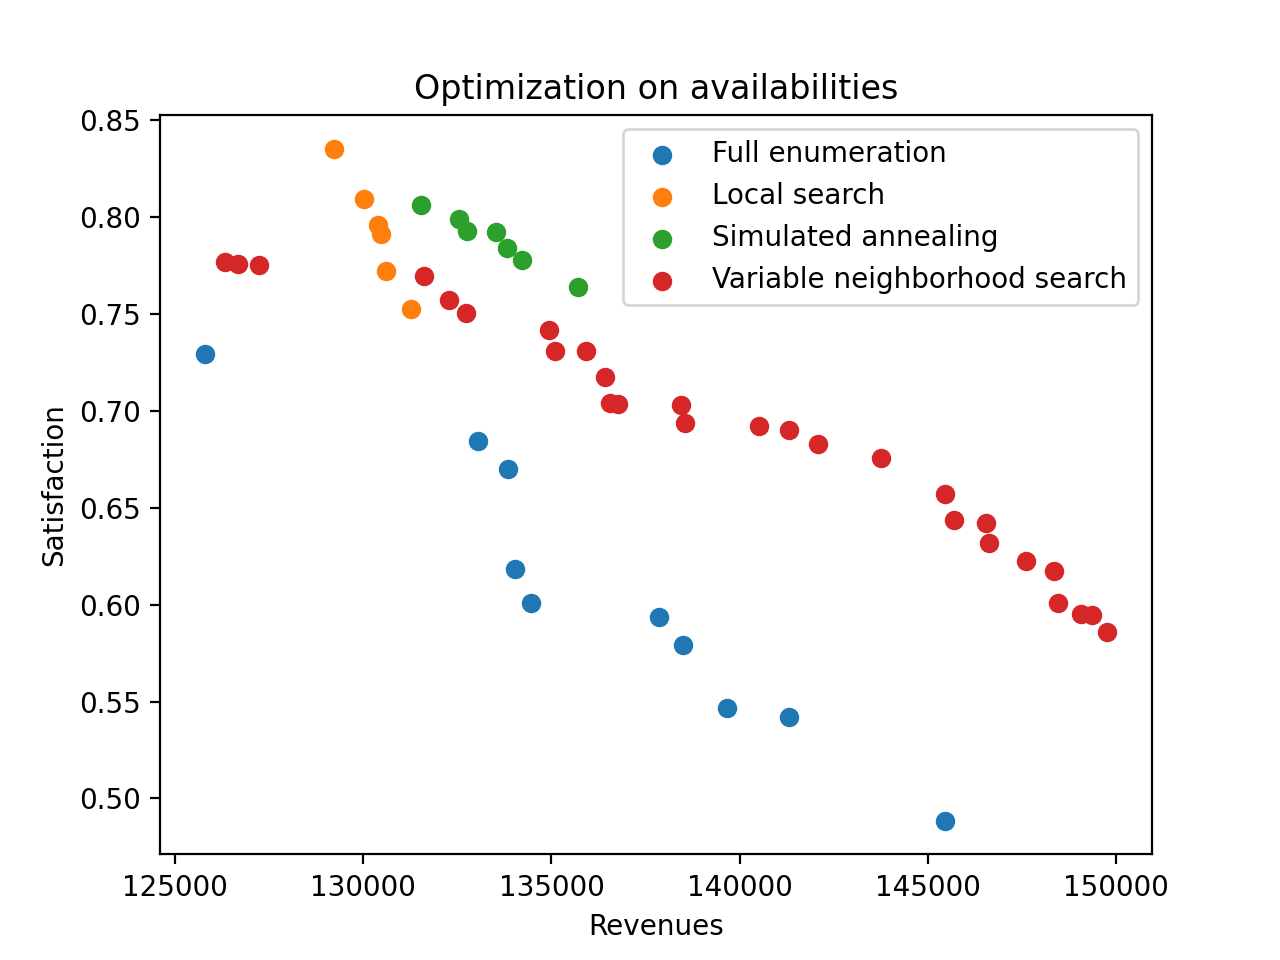

<IPython.core.display.Javascript object>


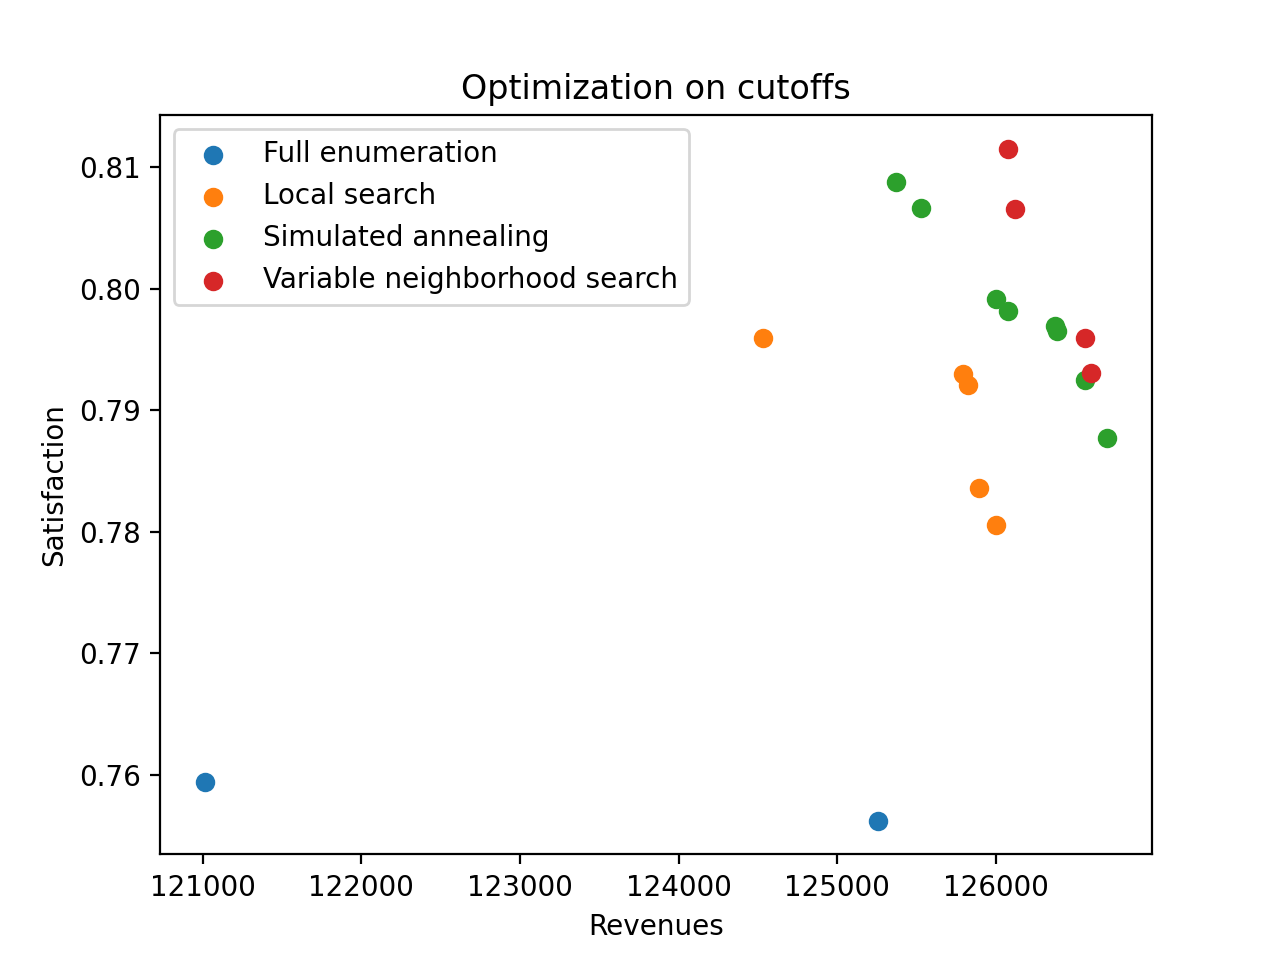

<IPython.core.display.Javascript object>


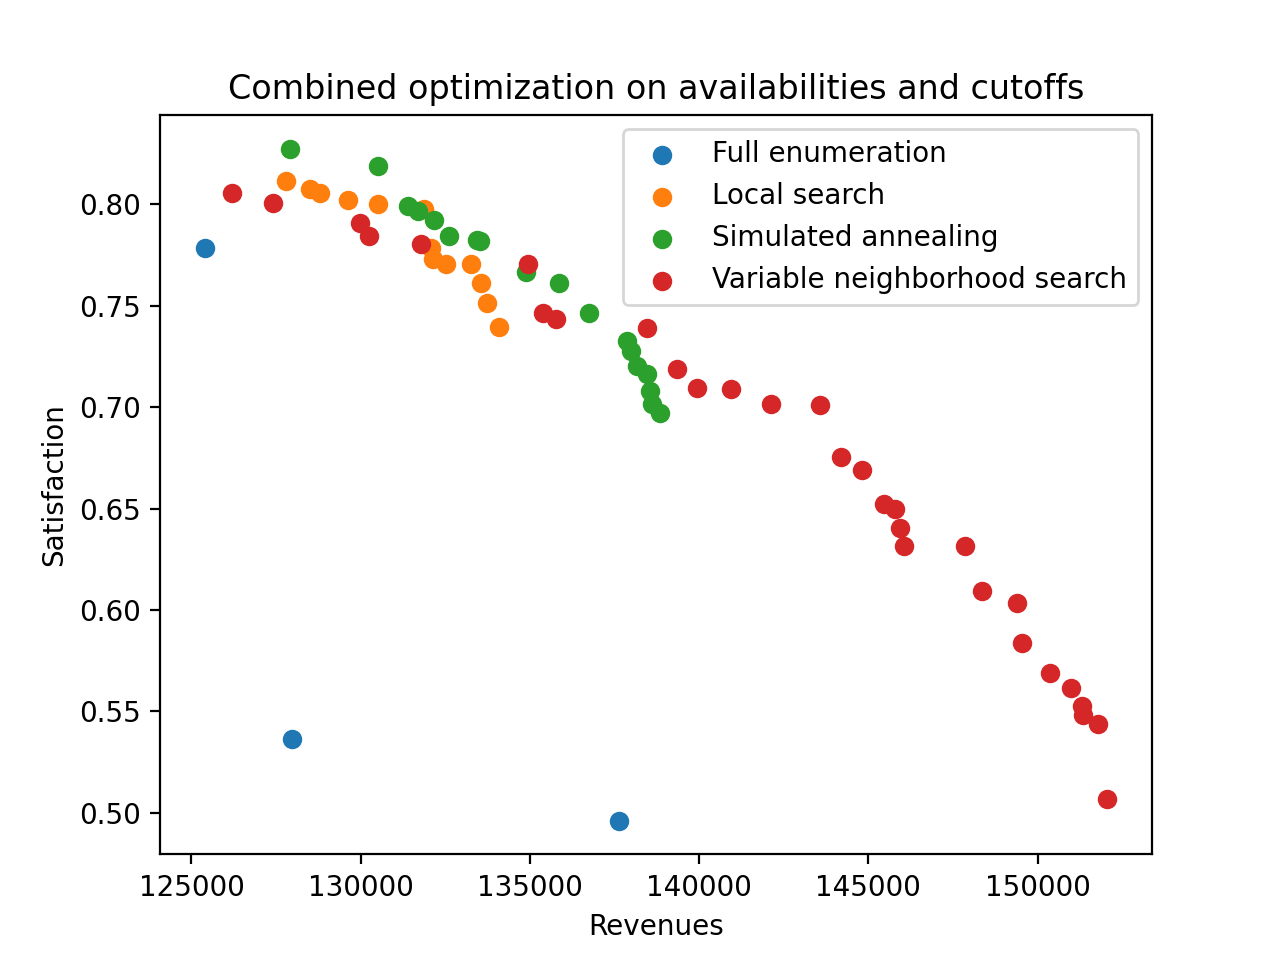

<IPython.core.display.Javascript object>


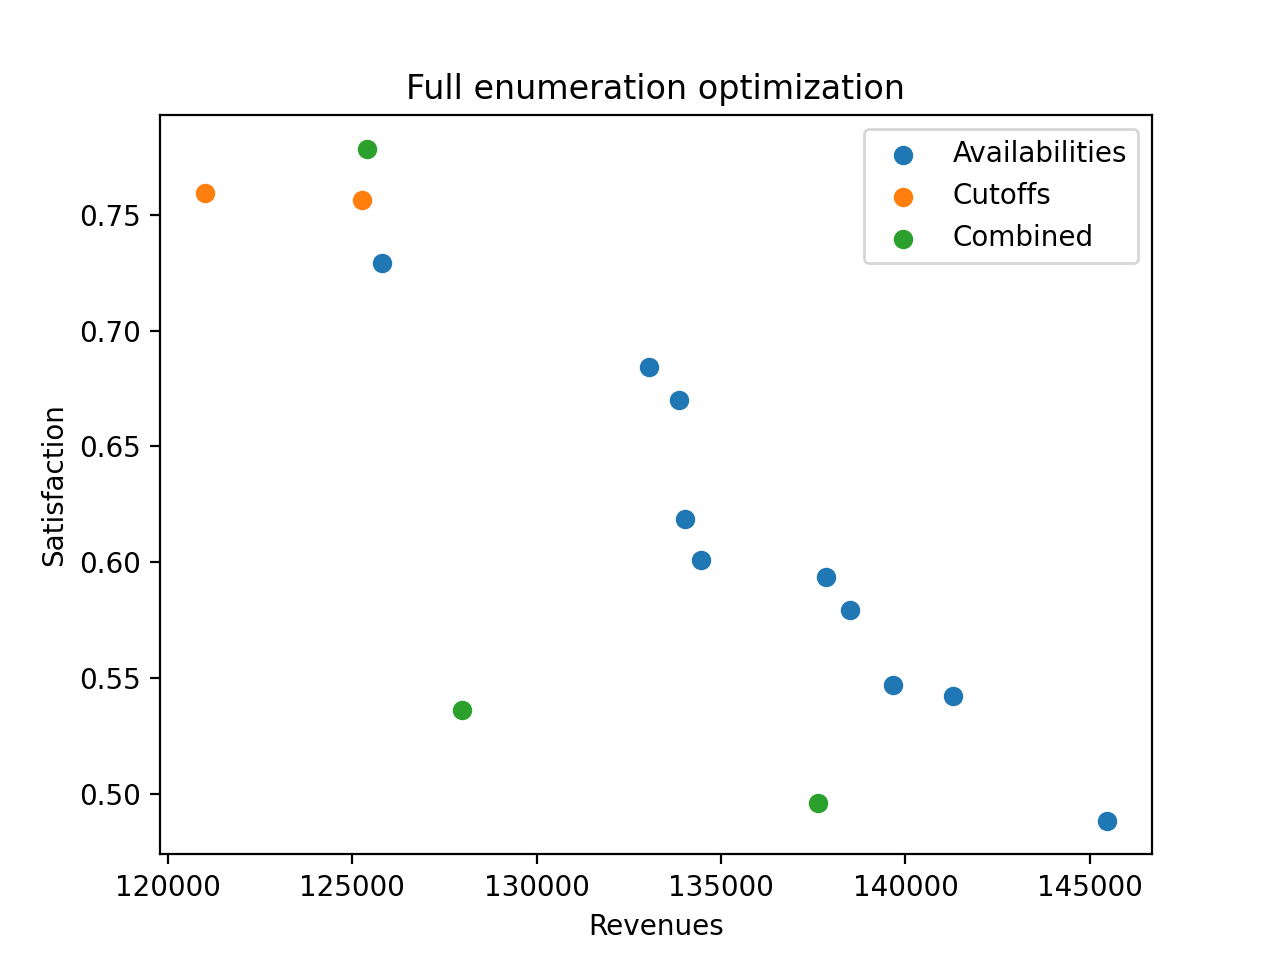

<IPython.core.display.Javascript object>


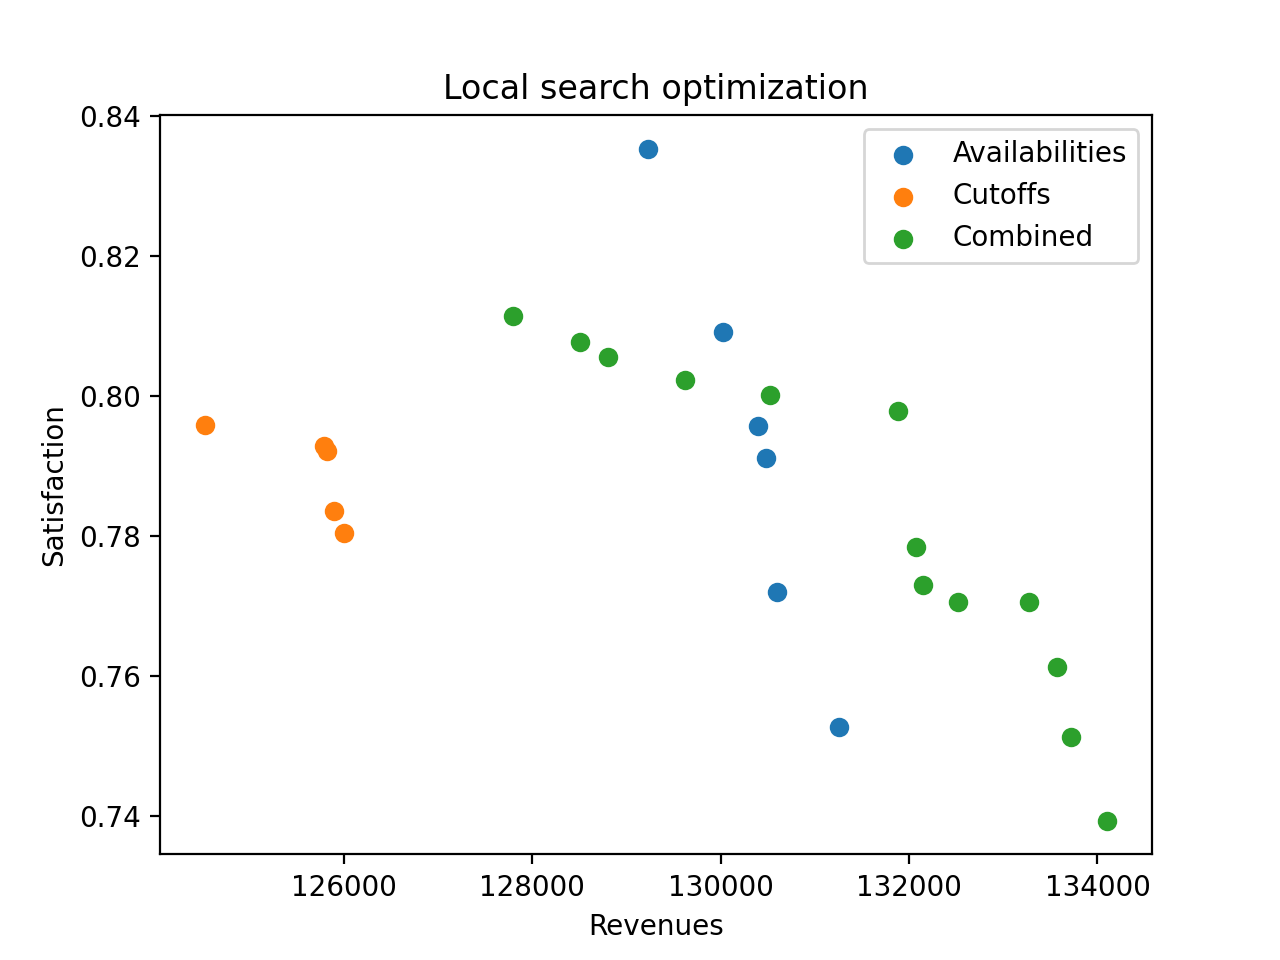

<IPython.core.display.Javascript object>


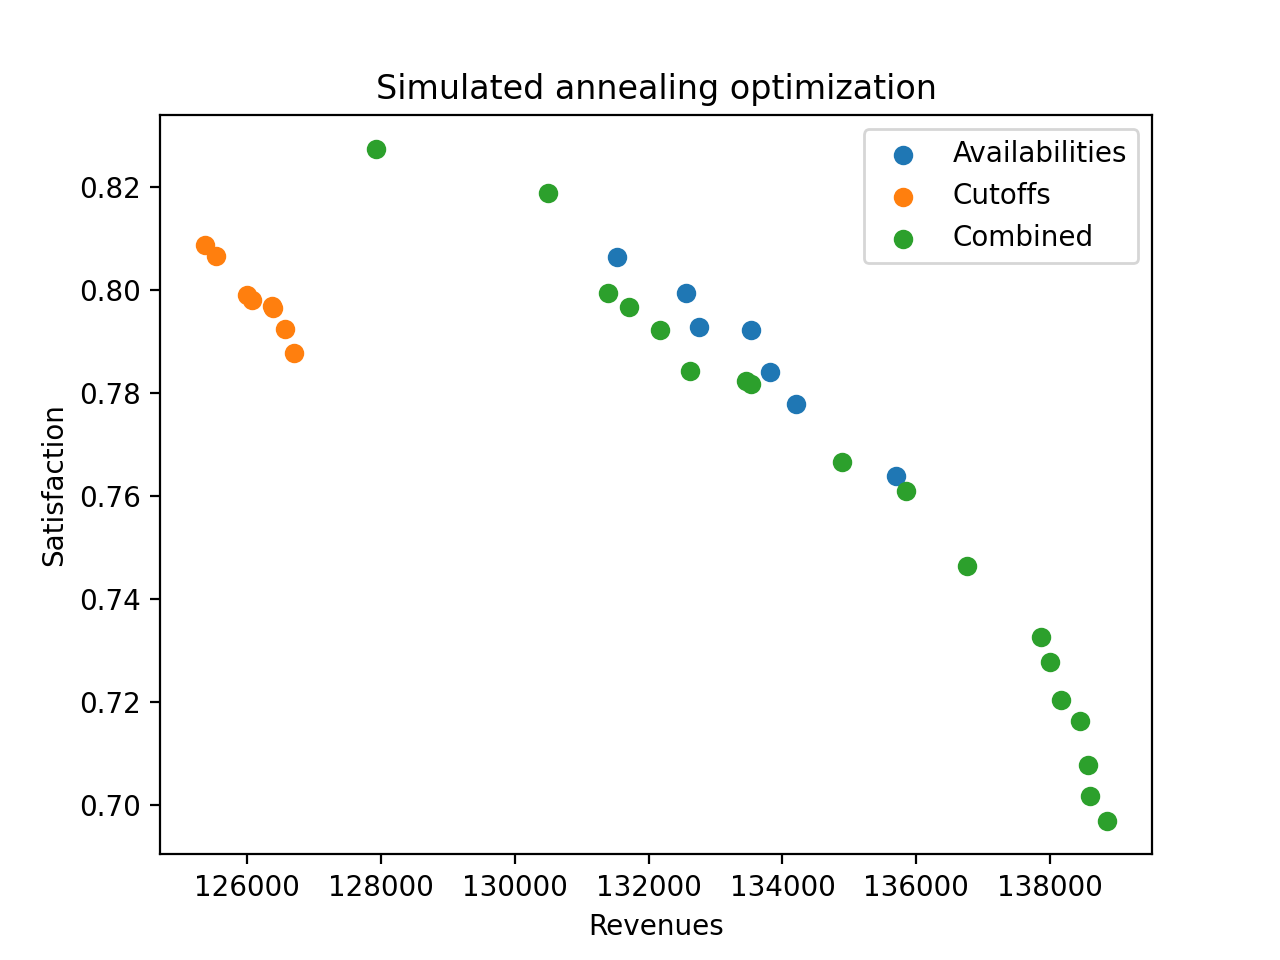

<IPython.core.display.Javascript object>


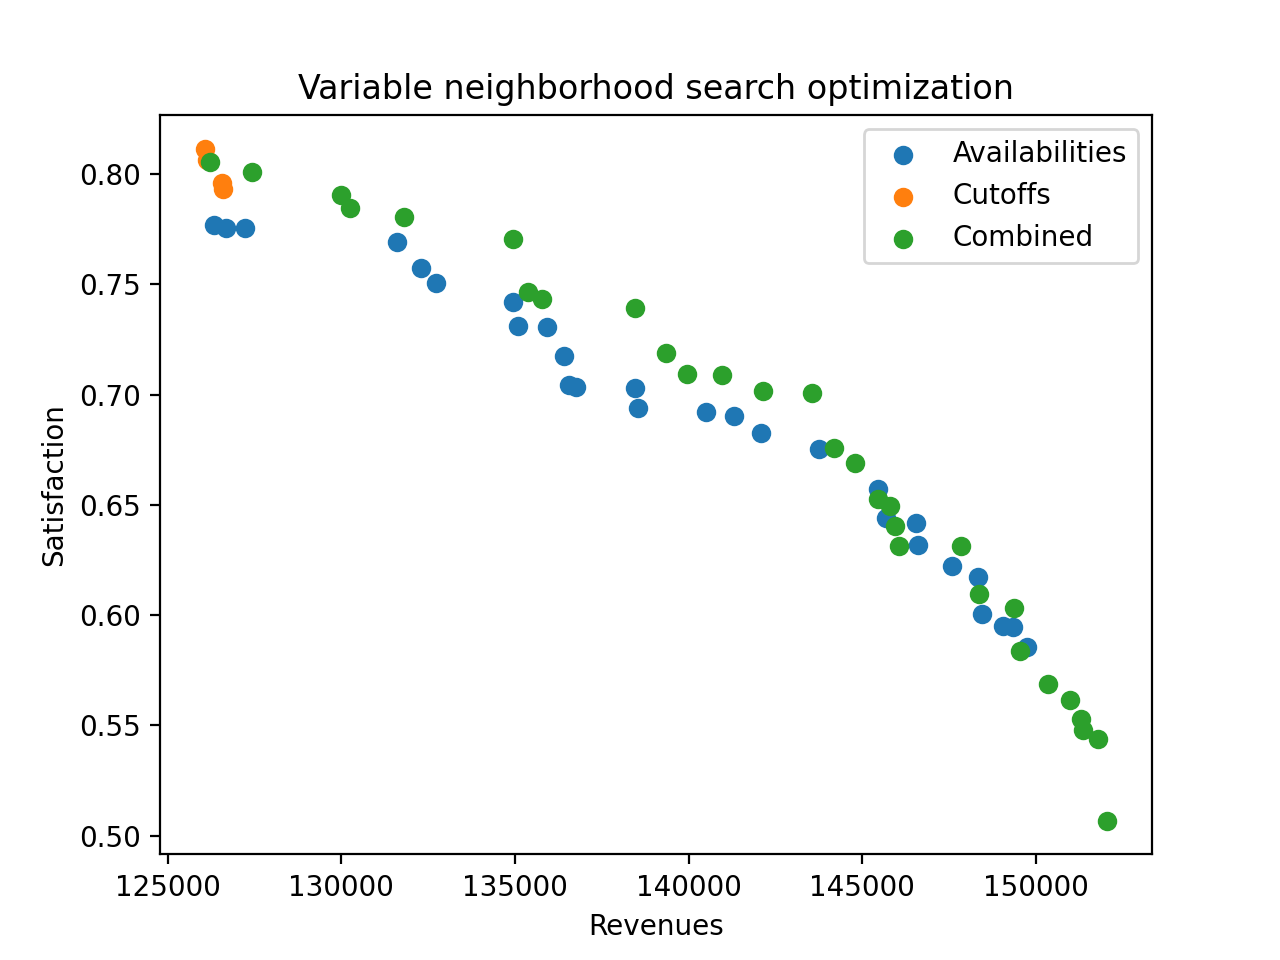

In [68]:
# Plots pareto front: availabilities

import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.scatter(np.array(best_revenue_fe_av)[:,0],np.array(best_revenue_fe_av)[:,1], label='Full enumeration')
plt.scatter(np.array(best_revenue_ls_av)[:,0],np.array(best_revenue_ls_av)[:,1], label='Local search')
plt.scatter(np.array(best_revenue_sa_av)[:,0],np.array(best_revenue_sa_av)[:,1], label='Simulated annealing')
plt.scatter(np.array(best_revenue_vns_av)[:,0],np.array(best_revenue_vns_av)[:,1], label='Variable neighborhood search')
plt.xlabel('Revenues')
plt.ylabel('Satisfaction')
plt.title('Optimization on availabilities')
plt.legend()
plt.show()

# Plots pareto front: cutoffs
plt.figure()
plt.scatter(np.array(best_revenue_fe_cf)[:,0],np.array(best_revenue_fe_cf)[:,1], label='Full enumeration')
plt.scatter(np.array(best_revenue_ls_cf)[:,0],np.array(best_revenue_ls_cf)[:,1], label='Local search')
plt.scatter(np.array(best_revenue_sa_cf)[:,0],np.array(best_revenue_sa_cf)[:,1], label='Simulated annealing')
plt.scatter(np.array(best_revenue_vns_cf)[:,0],np.array(best_revenue_vns_cf)[:,1], label='Variable neighborhood search')
plt.xlabel('Revenues')
plt.ylabel('Satisfaction')
plt.title('Optimization on cutoffs')
plt.legend()
plt.show()

# Plots pareto front: combined
plt.figure()
plt.scatter(np.array(best_revenue_fe_combined)[:,0],np.array(best_revenue_fe_combined)[:,1], label='Full enumeration')
plt.scatter(np.array(best_revenue_ls_combined)[:,0],np.array(best_revenue_ls_combined)[:,1], label='Local search')
plt.scatter(np.array(best_revenue_sa_combined)[:,0],np.array(best_revenue_sa_combined)[:,1], label='Simulated annealing')
plt.scatter(np.array(best_revenue_vns_combined)[:,0],np.array(best_revenue_vns_combined)[:,1], label='Variable neighborhood search')
plt.xlabel('Revenues')
plt.ylabel('Satisfaction')
plt.title('Combined optimization on availabilities and cutoffs')
plt.legend()
plt.show()

# Plots pareto front: full enumeration
plt.figure()
plt.scatter(np.array(best_revenue_fe_av)[:,0],np.array(best_revenue_fe_av)[:,1], label='Availabilities')
plt.scatter(np.array(best_revenue_fe_cf)[:,0],np.array(best_revenue_fe_cf)[:,1], label='Cutoffs')
plt.scatter(np.array(best_revenue_fe_combined)[:,0],np.array(best_revenue_fe_combined)[:,1], label='Combined')
plt.xlabel('Revenues')
plt.ylabel('Satisfaction')
plt.title('Full enumeration optimization')
plt.legend()
plt.show()

plt.figure()
plt.scatter(np.array(best_revenue_ls_av)[:,0],np.array(best_revenue_ls_av)[:,1], label='Availabilities')
plt.scatter(np.array(best_revenue_ls_cf)[:,0],np.array(best_revenue_ls_cf)[:,1], label='Cutoffs')
plt.scatter(np.array(best_revenue_ls_combined)[:,0],np.array(best_revenue_ls_combined)[:,1], label='Combined')
plt.xlabel('Revenues')
plt.ylabel('Satisfaction')
plt.title('Local search optimization')
plt.legend()
plt.show()

plt.figure()
plt.scatter(np.array(best_revenue_sa_av)[:,0],np.array(best_revenue_sa_av)[:,1], label='Availabilities')
plt.scatter(np.array(best_revenue_sa_cf)[:,0],np.array(best_revenue_sa_cf)[:,1], label='Cutoffs')
plt.scatter(np.array(best_revenue_sa_combined)[:,0],np.array(best_revenue_sa_combined)[:,1], label='Combined')
plt.xlabel('Revenues')
plt.ylabel('Satisfaction')
plt.title('Simulated annealing optimization')
plt.legend()
plt.show()

plt.figure()
plt.scatter(np.array(best_revenue_vns_av)[:,0],np.array(best_revenue_vns_av)[:,1], label='Availabilities')
plt.scatter(np.array(best_revenue_vns_cf)[:,0],np.array(best_revenue_vns_cf)[:,1], label='Cutoffs')
plt.scatter(np.array(best_revenue_vns_combined)[:,0],np.array(best_revenue_vns_combined)[:,1], label='Combined')
plt.xlabel('Revenues')
plt.ylabel('Satisfaction')
plt.title('Variable neighborhood search optimization')
plt.legend()
plt.show()




In [69]:
np.save("best_soln.npy", best_soln_all)
np.save("best_revenue.npy", best_revenue_all)
np.save("tracker.npy", tracker_all)

In [100]:
# Highest income solution
best_revenue_vns_combined = np.array(best_revenue_vns_combined)
index_hi = np.argmax(best_revenue_vns_combined[:, 0])
print(f'Highest income solution:\n{best_soln_vns_combined[index_hi]}\n')

# Highest satisfaction solution
best_revenue_ls_combined = np.array(best_revenue_ls_combined)
index_hs = np.argmax(best_revenue_ls_combined[:, 1])
print(f'Highest satisfaction solution:\n{best_soln_ls_combined[index_hs]}\n')

Highest income solution:
[array([ 0.,  0.,  6., 25., 17., 18., 28., 30., 56., inf]), array([ 0.,  1.,  3., 23.,  2.,  4.,  1., 17.,  3.,  0.])]

Highest satisfaction solution:
[array([15., 18., 21., 20., 21., 19., 21., 22., 23., inf]), array([ 1.,  1.,  2., 21.,  1.,  1.,  2., 21.,  0.,  0.])]



# Statistical analysis on selected solutions

In [108]:
# Highest income solution
av = best_soln_vns_combined[index_hi][0]
cf = best_soln_vns_combined[index_hi][1]

# Highest satisfaction
#av = best_soln_ls_combined[index_hs][0]
#cf = best_soln_ls_combined[index_hs][1]

In [109]:
def moving_mean_var(new_data, old_mean, old_var, t):
    """ Calculates moving sample mean and variance at time t.
    
    Keywords:
        new_data (float): new data point arriving at time t.
        old_mean (float): previous sample mean.
        old_var (float): previous sample variance.
        t (int): time index
    
    Returns:
        new_mean (float): updated sample mean.
        new_var (float): updated sample variance.
    """
    
    new_mean = old_mean + (new_data - old_mean)/(t + 1)
    new_var = (1 - 1/t)*old_var + (t + 1)*(new_mean - old_mean)**2
    
    return new_mean, new_var

In [110]:
t = 0 # Counter for the simulation runs

r_mean = 0 # Initialise the average of the revenues to 0
r_var = 0  # Initialise the variance of the revenues to 0
# Initialise empty lists that will collect: revenue during a run of the simulator, evolution of the average and variance of the revenues during the performed runs
r_list, r_mean_list, r_var_list = ([] for i in range(3)) 

s_mean = 0 # Initialise the average of the seats sold to 0
s_var = 0  # Initialise the variance of the seats sold to 0
# Initialise empty lists that will collect: seats sold during a run of the simulator, evolution of the average and variance of the seats sold during the performed runs
s_list, s_mean_list, s_var_list = ([] for i in range(3))

l_mean = 0 # Initialise the average of the late passengers to 0
l_var = 0  # Initialise the variance of the late passengers to 0
# Initialise empty lists that will collect: late passengers during a run of the simulator, evolution of the average and variance of the late passengers during the performed runs
l_list, l_mean_list, l_var_list = ([] for i in range(3)) 

sa_mean = 0 # Initialise the average of the passengers satisfaction to 0
sa_var = 0  # Initialise the variance of the passengers satisfaction to 0
# Initialise empty lists that will collect: passengers satisfaction during a run of the simulator, evolution of the average and variance of the passengers satisfaction during the performed runs
sa_list, sa_mean_list, sa_var_list = ([] for i in range(3)) 

# Stopping criterion: achieve the target precision and perform at least 100 simulation runs
precision = 0.5
done = False

# Main loop
while not(done):
    # Run the simulator
    revenue, seats, late, satisfaction = simulate(Scenario(availabilities=av,cutoffs=cf, days = 179))[2:]

    # Store the values obtained during each simulation run to perform a statistical analysis 
    if t == 0:
        # We only have one sample, don't need to update the variance!
        r_mean = revenue 
        s_mean = seats
        l_mean = late
        sa_mean = satisfaction
    else:
        r_mean, r_var = moving_mean_var(revenue, r_mean, r_var, t)
        s_mean, s_var = moving_mean_var(seats, s_mean, s_var, t)
        l_mean, l_var = moving_mean_var(late, l_mean, l_var, t)
        sa_mean, sa_var = moving_mean_var(satisfaction, sa_mean, sa_var, t)
    
    r_list.append(revenue)
    r_mean_list.append(r_mean)
    r_var_list.append(r_var)
    
    s_list.append(seats)
    s_mean_list.append(s_mean)
    s_var_list.append(s_var)
    
    l_list.append(late)
    l_mean_list.append(l_mean)
    l_var_list.append(l_var)
    
    sa_list.append(satisfaction)
    sa_mean_list.append(sa_mean)
    sa_var_list.append(sa_var)
    
    t += 1
    #if np.sqrt(r_var/t) < 10 and np.sqrt(s_var/t) < precision and np.sqrt(l_var/t) < precision and t >= 100:
    if t >= 1000:
        done = True # Exit the main loop

<IPython.core.display.Javascript object>


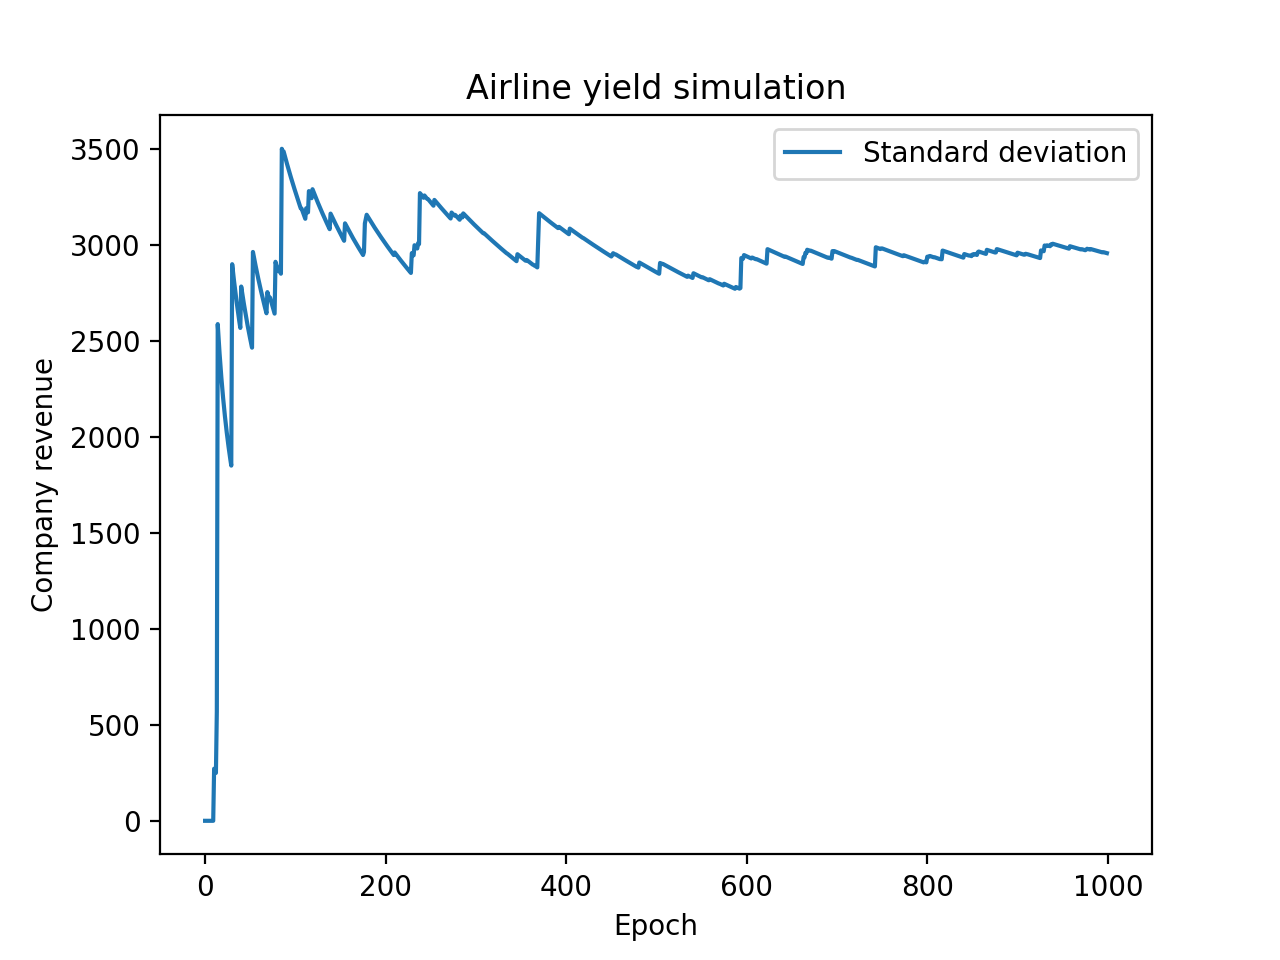

<IPython.core.display.Javascript object>


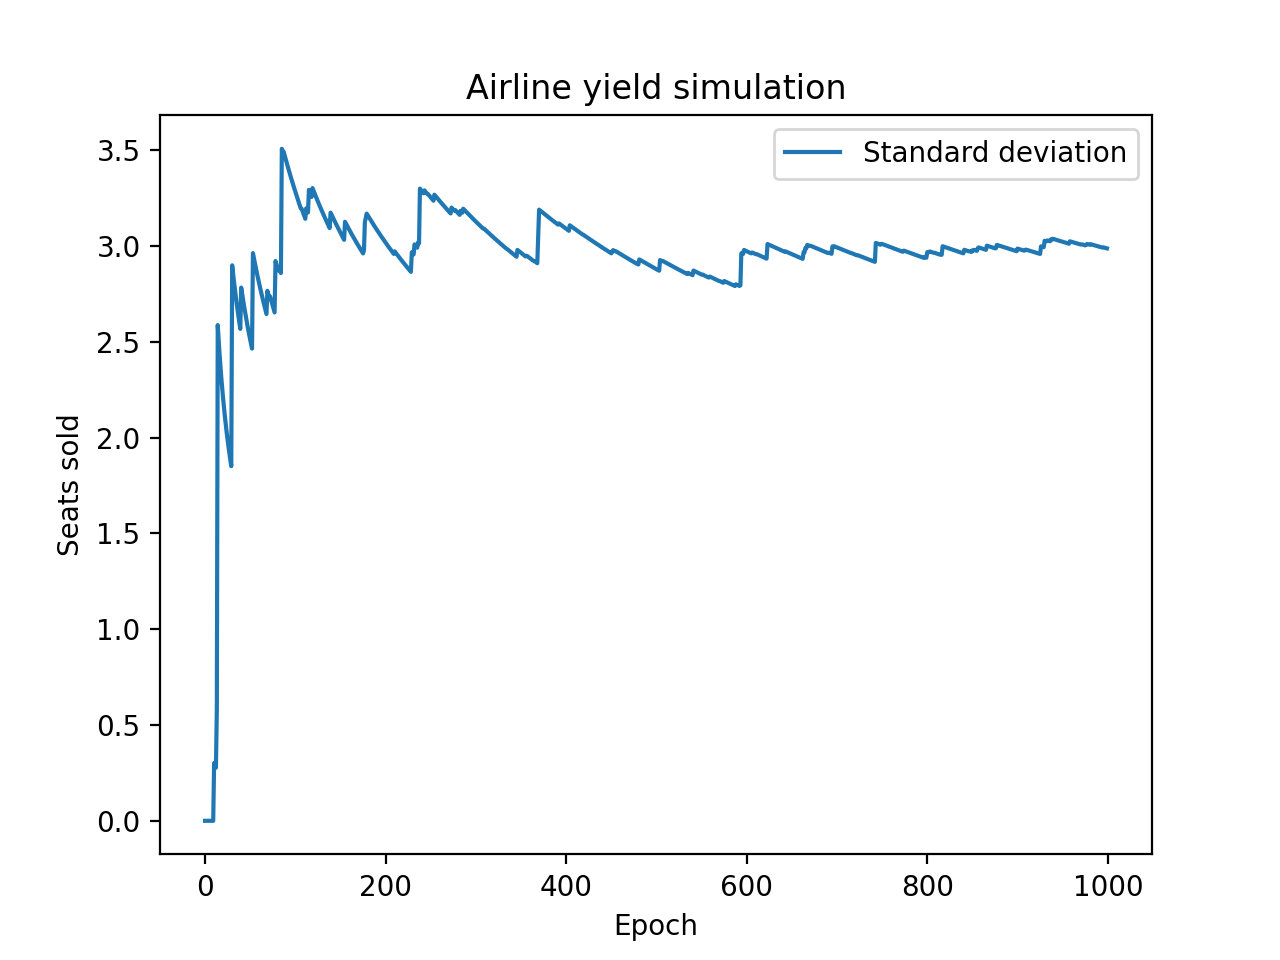

<IPython.core.display.Javascript object>


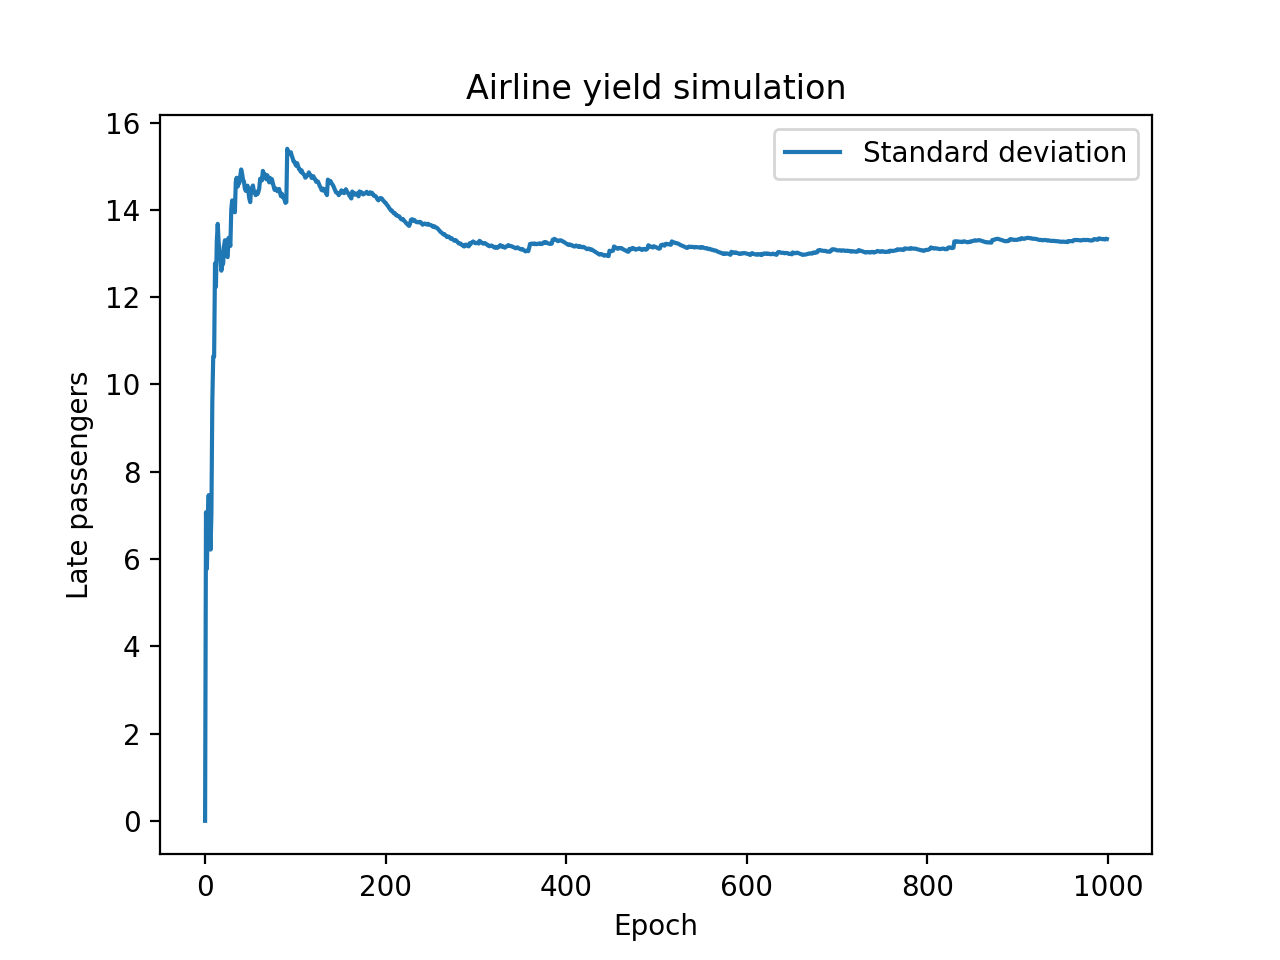

<IPython.core.display.Javascript object>


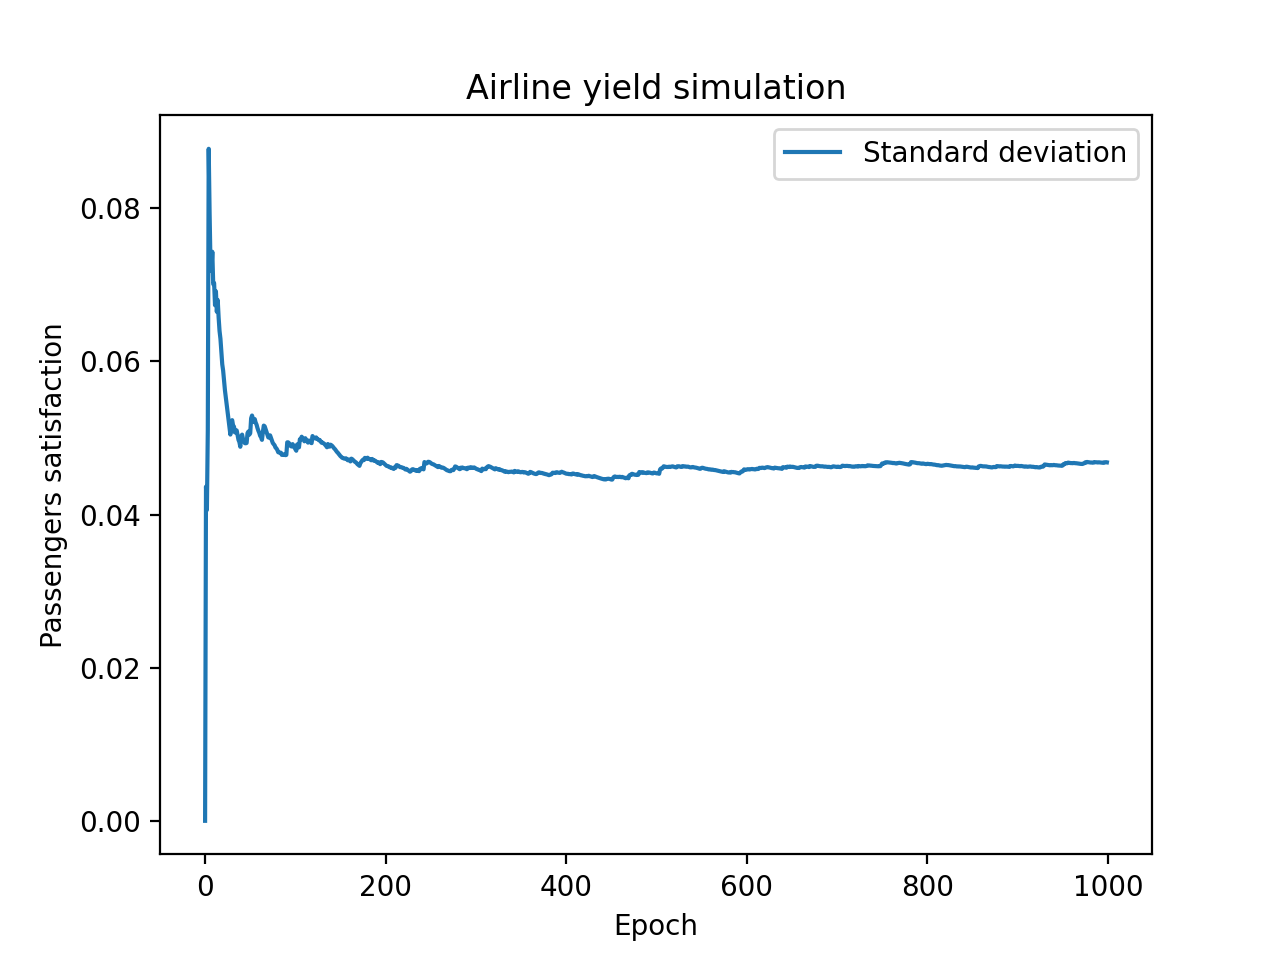

In [111]:
fig, ax = plt.subplots()

#ax.plot(r_mean_list, label = 'Mean value')
ax.plot(np.sqrt(r_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Company revenue', title = 'Airline yield simulation')
ax.legend()

plt.show()


fig, ax = plt.subplots()

#ax.plot(s_mean_list, label = 'Mean value')
ax.plot(np.sqrt(s_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Seats sold', title = 'Airline yield simulation')
ax.legend()

plt.show()


fig, ax = plt.subplots()

#ax.plot(l_mean_list, label = 'Mean value')
ax.plot(np.sqrt(l_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Late passengers', title = 'Airline yield simulation')
ax.legend()

plt.show()


fig, ax = plt.subplots()

#ax.plot(sa_mean_list, label = 'Mean value')
ax.plot(np.sqrt(sa_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Passengers satisfaction', title = 'Airline yield simulation')
ax.legend()

plt.show()

In [112]:
def bootstrap(data, f_statistic, draws):
    """ Calculates the bootstrap mse of a statistic of choice
    
    Keywords:
        data (array): data array.
        f_statistic: function handle calculating the statistic of interest.
        draws (int): number of bootstrap draws.
    
    Returns:
        mse (float): mean square error of the statistic of interest.
    """
    
    theta = f_statistic(data) # Compute the desired statistic over the empirical distribution
    mse = 0 # Initialise the mean square error to 0
    for i in range(draws):
        # Randomly choose samples from the dataset and recompute the statistic of interest
        indexes = np.floor(data.shape[0]*np.random.rand(data.shape[0]))
        samples = data[np.array(indexes).astype(int)]
        # Compute the total squared error
        mse += (theta - f_statistic(samples))**2
    # Take the mean diving by the number of iterations    
    mse = mse/draws
         
    return mse

In [113]:
# Define some function handles calculating statistics of interest
f_mean = lambda data: data.mean()
f_percentile = lambda data: np.quantile(data, 0.95)
f_min = lambda data: min(data)
f_max = lambda data: max(data)

***** Statistics on the airline company revenue *****

Mean: 151075.2
Bootstrapped MSE: 9281.626740000216
Theoretical MSE:  8733.92496

95% percentile: 145050.0
Bootstrapped MSE: 0.0



<IPython.core.display.Javascript object>


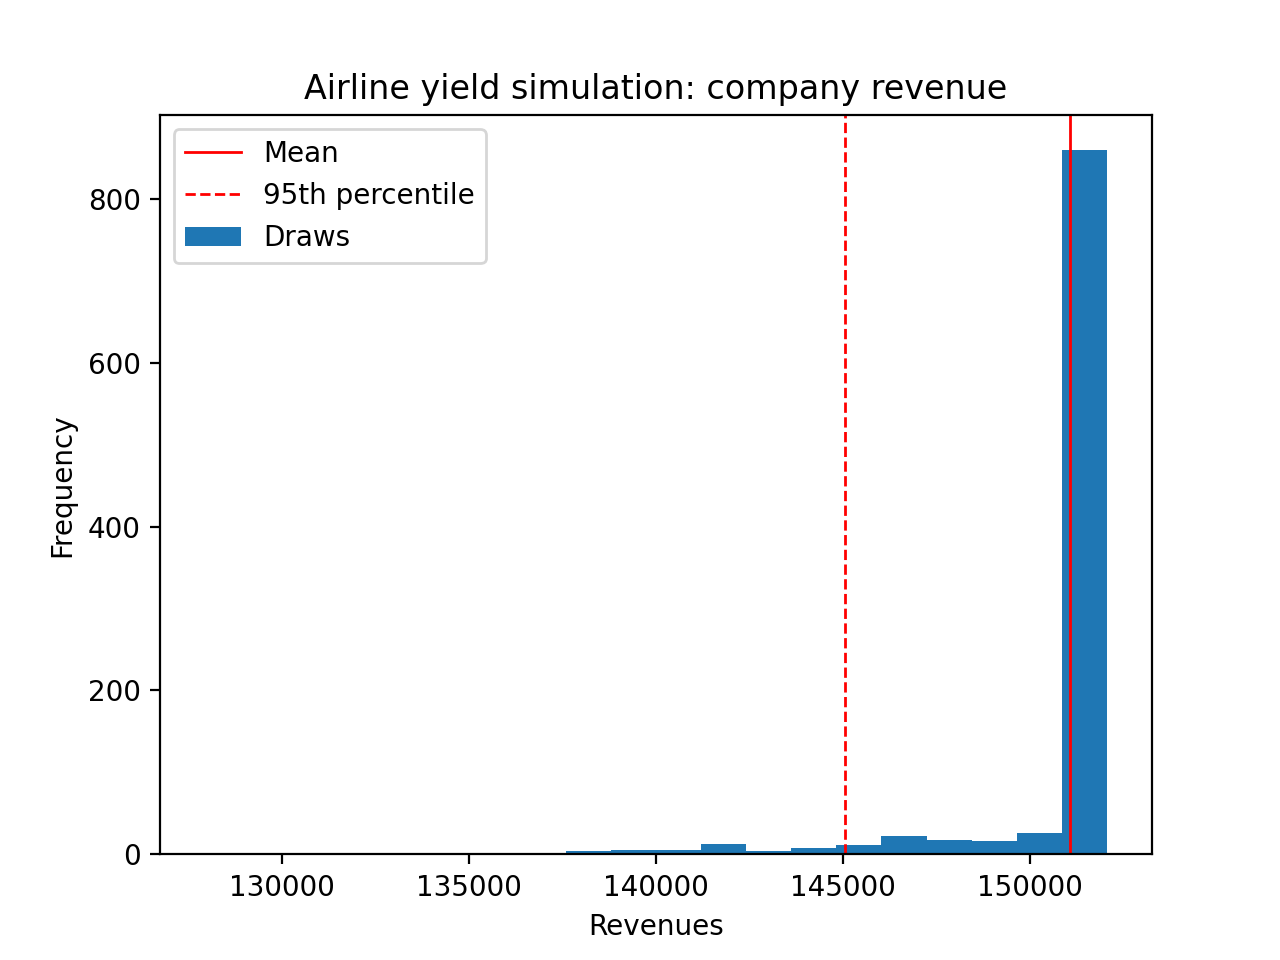


***** Statistics on the airline seats sold *****

Mean: 179.014
Bootstrapped MSE: 0.010116648000000075
Theoretical MSE:  0.008917804

95% percentile: 173.0
Bootstrapped MSE: 0.0

Worst case: 155
Bootstrapped MSE: 5.102


<IPython.core.display.Javascript object>


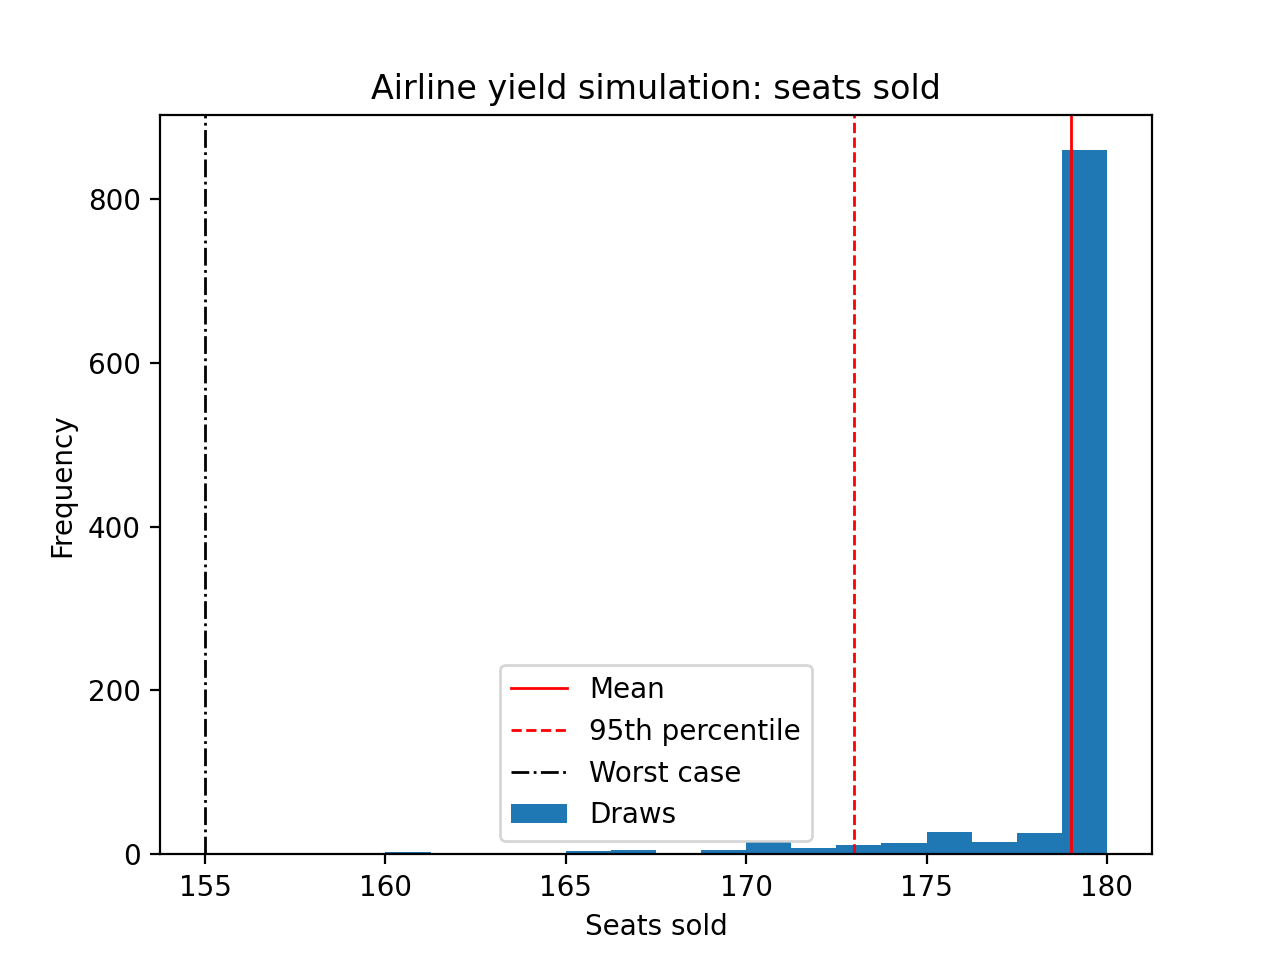


***** Statistics on the airline late passengers *****

Mean: 19.007
Bootstrapped MSE: 0.19216317999999977
Theoretical MSE:  0.17757295099999998

95% percentile: 42.0
Bootstrapped MSE: 2.1547849999999986

Worst case: 79
Bootstrapped MSE: 68.002


<IPython.core.display.Javascript object>


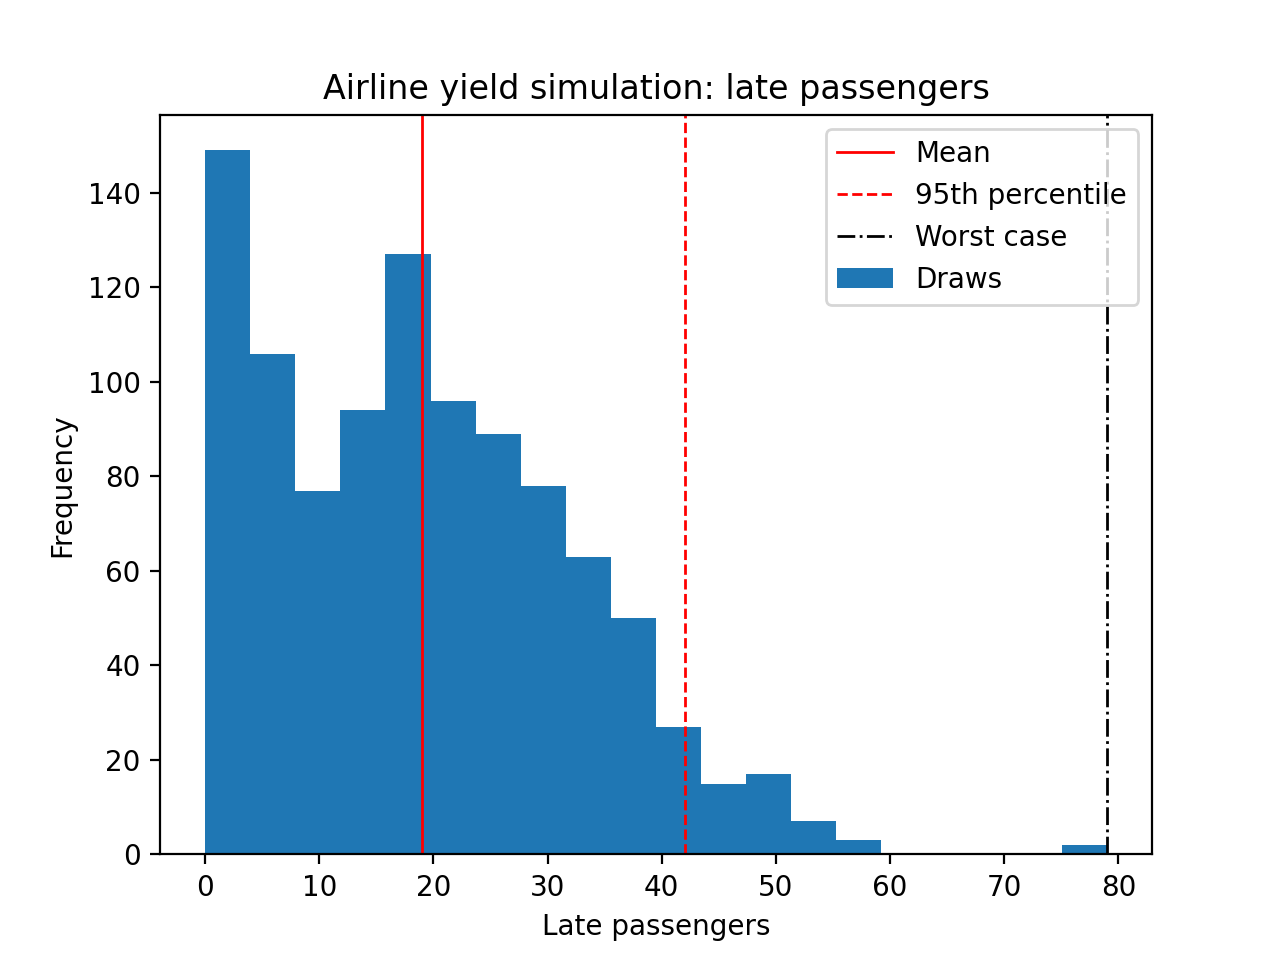


***** Statistics on the airline passengers satisfaction *****

Mean: 0.5395192270309297
Bootstrapped MSE: 2.1476087391148124e-06
Theoretical MSE:  2.18979214591017e-06

95% percentile: 0.46752033013715255
Bootstrapped MSE: 8.82530785733501e-06

Worst case: 0.3911290322580645
Bootstrapped MSE: 0.00015639826838900907


<IPython.core.display.Javascript object>


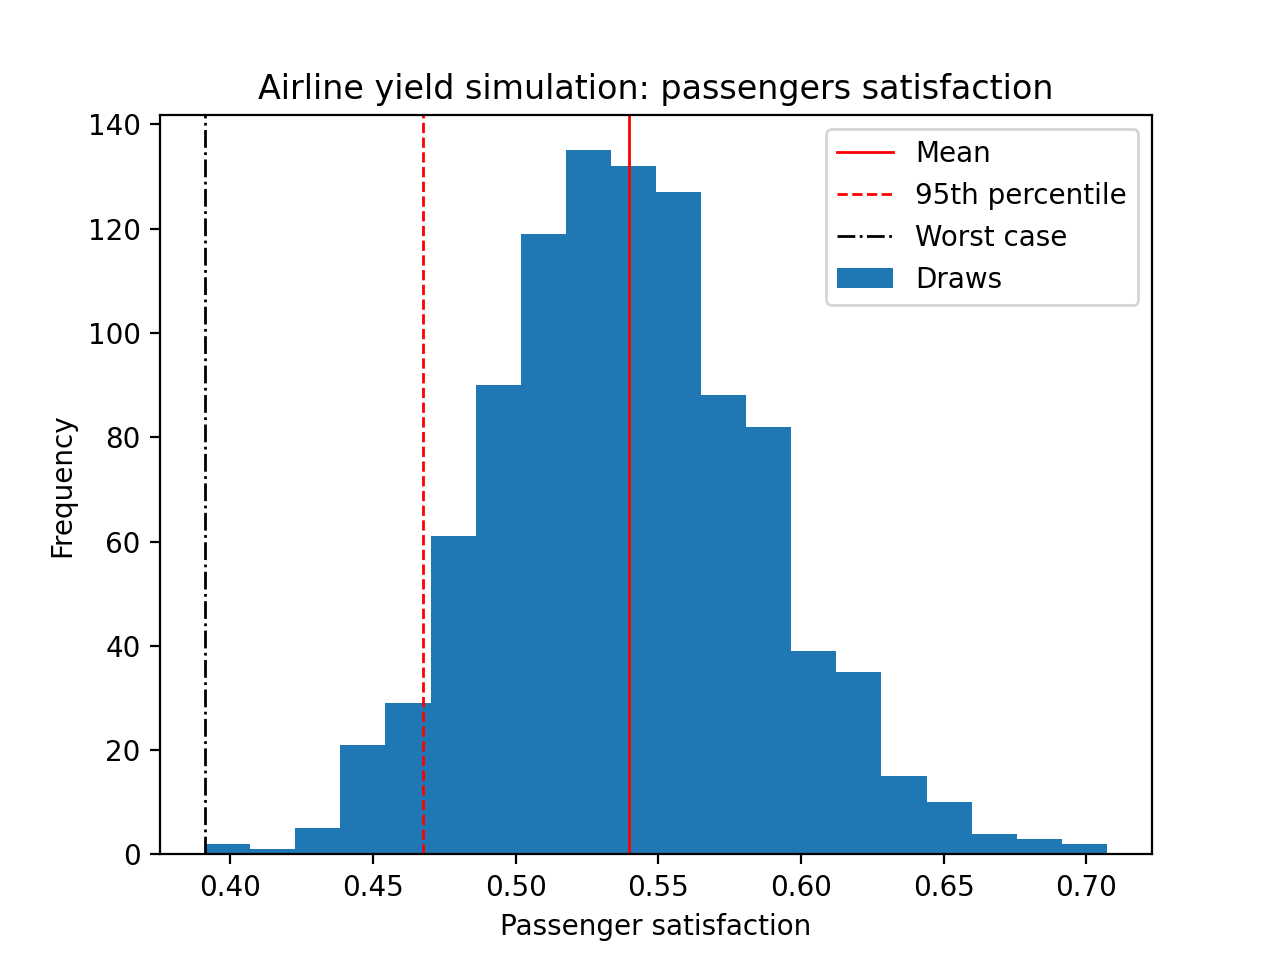

In [114]:
r_list = np.array(r_list) # For convenience
print(f'***** Statistics on the airline company revenue *****\n')

# Mean of the revenue
empirical_mean = f_mean(r_list) # Equals to r_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(r_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = r_list.var()/r_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the revenue
empirical_95p = f_percentile(-r_list)
print(f'95% percentile: {-empirical_95p}')
bootstrap_mse_95p = bootstrap(r_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

fig, ax = plt.subplots()

ax.hist(r_list, density = False, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(-empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')

ax.set(xlabel = 'Revenues', ylabel = 'Frequency', title = 'Airline yield simulation: company revenue')
ax.legend()

plt.show()


s_list = np.array(s_list) # For convenience
print(f'\n***** Statistics on the airline seats sold *****\n')

# Mean of the seats sold
empirical_mean = f_mean(s_list) # Equals to s_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(s_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = s_list.var()/s_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the seats sold
empirical_95p = f_percentile(-s_list)
print(f'95% percentile: {-empirical_95p}')
bootstrap_mse_95p = bootstrap(s_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

# Worst case of the seats sold
empirical_ws = f_min(s_list)
print(f'Worst case: {empirical_ws}')
bootstrap_mse_ws = bootstrap(s_list, f_min, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_ws}')

fig, ax = plt.subplots()

ax.hist(s_list, density = False, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(-empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')
plt.axvline(empirical_ws, color = 'k', linestyle = 'dashdot', linewidth = 1, label = 'Worst case')

ax.set(xlabel = 'Seats sold', ylabel = 'Frequency', title = 'Airline yield simulation: seats sold')
ax.legend()

plt.show()


l_list = np.array(l_list) # For convenience
print(f'\n***** Statistics on the airline late passengers *****\n')

# Mean of the seats sold
empirical_mean = f_mean(l_list) # Equals to s_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(l_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = l_list.var()/l_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the seats sold
empirical_95p = f_percentile(l_list)
print(f'95% percentile: {empirical_95p}')
bootstrap_mse_95p = bootstrap(l_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

# Worst case of the seats sold
empirical_ws = f_max(l_list)
print(f'Worst case: {empirical_ws}')
bootstrap_mse_ws = bootstrap(l_list, f_max, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_ws}')

fig, ax = plt.subplots()

ax.hist(l_list, density = False, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')
plt.axvline(empirical_ws, color = 'k', linestyle = 'dashdot', linewidth = 1, label = 'Worst case')

ax.set(xlabel = 'Late passengers', ylabel = 'Frequency', title = 'Airline yield simulation: late passengers')
ax.legend()

plt.show()


sa_list = np.array(sa_list) # For convenience
print(f'\n***** Statistics on the airline passengers satisfaction *****\n')

# Mean of the seats sold
empirical_mean = f_mean(sa_list) # Equals to s_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(sa_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = sa_list.var()/sa_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the seats sold
empirical_95p = f_percentile(-sa_list)
print(f'95% percentile: {-empirical_95p}')
bootstrap_mse_95p = bootstrap(sa_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

# Worst case of the seats sold
empirical_ws = f_min(sa_list)
print(f'Worst case: {empirical_ws}')
bootstrap_mse_ws = bootstrap(sa_list, f_min, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_ws}')

fig, ax = plt.subplots()

ax.hist(sa_list, density = False, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(-empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')
plt.axvline(empirical_ws, color = 'k', linestyle = 'dashdot', linewidth = 1, label = 'Worst case')

ax.set(xlabel = 'Passenger satisfaction', ylabel = 'Frequency', title = 'Airline yield simulation: passengers satisfaction')
ax.legend()

plt.show()